# **Modelo de Comitê Preditivo da Autonomia de Meio Operativo**
## **ATOp-PredictiveModel**
Este notebook organiza o código gerado para a análise da autonomia de uma plataforma naval da Marinha do Brasil, utilizando dados coletados entre 2013 e 2017.

## **Environment and Libraries**

In [83]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import (
    GradientBoostingRegressor,
    RandomForestRegressor,
    VotingRegressor,
)
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score, mean_squared_error, root_mean_squared_error

import ImbalancedLearningRegression as iblr
import optuna
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.model_selection import KFold, cross_val_score
from sklearn.preprocessing import StandardScaler

from itertools import combinations
import time

## **Integrate Historical Data from Military Naval Platform**

### **Loading Data**

In [2]:
# LOADING DATA

# load the SINGRA Dataset
df_Singra = pd.read_csv('C:/Users/12078956/Documents/Projeto/Dados/SINGRA/RMC_MEIO1.csv',
                        sep=',', header=0, parse_dates=['PERIODO'],
                        dtype={'QTDE_ITENS_RM': np.float64, 'PRECO_UNITARIO_VENDA': np.float64})
# load the RFC Dataset
df_RFC = pd.read_csv('C:/Users/12078956/Documents/Projeto/Dados/RFC/RFC.csv',
                     sep=',', header=0) #, dtype={'MILHAS': np.float64})

### **Data Exploration**

In [3]:
# Scrub SINGRA dataset

df_Singra.head(5)

,ANO,PERIODO,MES,SIGLA_OM,RM_TYPE,SITUACAO_RM,DESC_SITUACAO_RM,GRUPO_JURISDICAO,DESCRICAO_CLG,PI,NOME_PORTUGUES,UF,QTDE_ITENS_RM,PRECO_UNITARIO_VENDA
0,2013,2013-01-01,1,MEIO1,RMC,FN,FORNECIDA,COMBUSTIVEIS,ÓLEO DIESEL MARÍTIMO,190024045,ÓLEO DIESEL MARÍTIMO,LITRO,229000.0,NaN
1,2013,2013-01-01,1,MEIO1,RMC,FN,FORNECIDA,COMBUSTIVEIS,ÓLEO DIESEL MARÍTIMO,190024045,ÓLEO DIESEL MARÍTIMO,LITRO,230000.0,NaN
2,2013,2013-01-01,1,MEIO1,RMC,FN,FORNECIDA,COMBUSTIVEIS,ÓLEO DIESEL MARÍTIMO,190024045,ÓLEO DIESEL MARÍTIMO,LITRO,120000.0,NaN
3,2013,2013-02-01,2,MEIO1,RMC,FN,FORNECIDA,SUBSISTENCIA,* SEM TIPO CLG *,190010170,LOMBO EM PEDAÇOS,QUILOGRAMA,160.0,7.32
4,2013,2013-02-01,2,MEIO1,RMC,FN,FORNECIDA,SUBSISTENCIA,* SEM TIPO CLG *,190015262,GELÉIA,QUILOGRAMA,36.0,3.40


In [4]:
df_Singra.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1826 entries, 0 to 1825
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   ANO                   1826 non-null   int64         
 1   PERIODO               1826 non-null   datetime64[ns]
 2   MES                   1826 non-null   int64         
 3   SIGLA_OM              1826 non-null   object        
 4   RM_TYPE               1826 non-null   object        
 5   SITUACAO_RM           1826 non-null   object        
 6   DESC_SITUACAO_RM      1826 non-null   object        
 7   GRUPO_JURISDICAO      1826 non-null   object        
 8   DESCRICAO_CLG         1818 non-null   object        
 9   PI                    1826 non-null   object        
 10  NOME_PORTUGUES        1826 non-null   object        
 11  UF                    1826 non-null   object        
 12  QTDE_ITENS_RM         1826 non-null   float64       
 13  PRECO_UNITARIO_VEN

In [5]:
df_Singra['GRUPO_JURISDICAO'].value_counts()

GRUPO_JURISDICAO
SUBSISTENCIA    1478
COMBUSTIVEIS     348
Name: count, dtype: int64

In [6]:
# Remove consumable items outside the scope of work
df_Singra = df_Singra.drop(df_Singra.loc[lambda df_GENEROS: ((df_Singra.NOME_PORTUGUES == 'REFEIÇÃO INDIVIDUAL') |
                                                              (df_Singra.NOME_PORTUGUES == 'RAÇÃO DE SOBREVIVÊNCIA'))].index, axis=0)

In [7]:
# Standardization of the Supply Unit (SU)
print('UF antes:')
print(df_Singra['UF'].value_counts())
print('\n')

# 1 Pack of coffee = 0.5 kilogram
df_Singra['QTDE_ITENS_RM'] = df_Singra.apply(lambda x: x.QTDE_ITENS_RM*0.5 if x.UF == 'PACOTE'
                                             else x.QTDE_ITENS_RM, axis = 1)
# change the description
df_Singra['UF'] = df_Singra.UF.replace('PACOTE', 'QUILOGRAMA')

# 1 Bottle of vegetable oil = 0.9 liter
df_Singra['QTDE_ITENS_RM'] = df_Singra.apply(lambda x: x.QTDE_ITENS_RM*0.9 if x.UF == 'GARRAFA'
                                             else x.QTDE_ITENS_RM, axis = 1)
df_Singra['UF'] = df_Singra.UF.replace('GARRAFA', 'LITRO') # change the description

# 1 US Quarter Gallon of lubricant = 0.946353 liter
df_Singra['QTDE_ITENS_RM'] = df_Singra.apply(lambda x: x.QTDE_ITENS_RM*0.946353 if x.UF == 'QUARTO DE GALAO AMERICANO'
                                             else x.QTDE_ITENS_RM, axis = 1)
# 1 drum of lubricant = 200 liters
df_Singra['QTDE_ITENS_RM'] = df_Singra.apply(lambda x: x.QTDE_ITENS_RM*200 if x.UF == 'TAMBOR'
                                             else x.QTDE_ITENS_RM, axis = 1)

# 1 Gallon of lubricant = 3.785412 liters
df_Singra['QTDE_ITENS_RM'] = df_Singra.apply(lambda x: x.QTDE_ITENS_RM*3.785412 if x.UF == 'GALAO'
                                             else x.QTDE_ITENS_RM, axis = 1)

# 1 Bucket of lubricant = 20 liters
# 1 Bucket of grease = 20 kilograms
df_Singra['QTDE_ITENS_RM'] = df_Singra.apply(lambda x: x.QTDE_ITENS_RM*20 if x.UF == 'BALDE'
                                             else x.QTDE_ITENS_RM, axis = 1)
# 1 Can of grease = 5 kilograms
df_Singra['QTDE_ITENS_RM'] = df_Singra.apply(lambda x: x.QTDE_ITENS_RM*5 if x.UF == 'LATA'
                                             else x.QTDE_ITENS_RM, axis = 1)

# Change UF description for Lubricant and Grease
df_Singra['UF'] = df_Singra.apply(lambda x: 'LITRO' if x.DESCRICAO_CLG == 'LUBRIFICANTE'
                                  else 'QUILOGRAMA' if x.DESCRICAO_CLG == 'GRAXA' else x.UF, axis = 1)

print('UF depois:')
print(df_Singra['UF'].value_counts())

UF antes:
UF
QUILOGRAMA                   1247
LITRO                         421
BALDE                          58
TAMBOR                         49
GARRAFA                        35
GALAO                           6
QUARTO DE GALAO AMERICANO       3
PACOTE                          3
LATA                            1
Name: count, dtype: int64


UF depois:
UF
QUILOGRAMA    1260
LITRO          563
Name: count, dtype: int64


In [8]:
df_CLG = df_Singra.query('GRUPO_JURISDICAO == "COMBUSTIVEIS"')

In [9]:
df_CLG['DESCRICAO_CLG'].value_counts()

DESCRICAO_CLG
LUBRIFICANTE                   114
ÓLEO DIESEL MARÍTIMO            90
ÓLEO DIESEL ESPECIAL - OCMT     81
COMBUSTÍVEL AVIAÇÃO - QAV-5     34
GRAXA                           14
GASOLINA COMUM                   7
Name: count, dtype: int64

In [10]:
# Remove consumable items outside the scope of work
df_CLG = df_CLG.drop(df_CLG.loc[lambda df_CLG: ((df_CLG.DESCRICAO_CLG == 'COMBUSTÍVEL AVIAÇÃO - QAV-5')
                                                | (df_CLG.DESCRICAO_CLG == 'GASOLINA COMUM'))].index, axis=0)

In [11]:
df_CLG['DESCRICAO_CLG'].value_counts()

DESCRICAO_CLG
LUBRIFICANTE                   114
ÓLEO DIESEL MARÍTIMO            90
ÓLEO DIESEL ESPECIAL - OCMT     81
GRAXA                           14
Name: count, dtype: int64

In [12]:
# Standardization of the description of CLG types
df_CLG['DESCRICAO_CLG'] = df_CLG.DESCRICAO_CLG.replace('ÓLEO DIESEL ESPECIAL - OCMT', 'COMBUSTIVEL')
df_CLG['DESCRICAO_CLG'] = df_CLG.DESCRICAO_CLG.replace('ÓLEO DIESEL MARÍTIMO', 'COMBUSTIVEL')

In [13]:
df_CLG['DESCRICAO_CLG'].value_counts()

DESCRICAO_CLG
COMBUSTIVEL     171
LUBRIFICANTE    114
GRAXA            14
Name: count, dtype: int64

In [14]:
# import warnings
# warnings.simplefilter("ignore", category=FutureWarning)
# # plotly code
# fig1 = px.scatter(df_CLG, x = df_CLG.PERIODO,
#                   y = df_CLG.QTDE_ITENS_RM,
#                   color=df_CLG.DESCRICAO_CLG)
# fig1.update_layout(
#     title='CLG consumption data by observation period',
#     xaxis_title='Period',
#     yaxis_title='CLG quantity',
#     legend_title='Consumption Categories',
# )
# fig1.show(renderer='png', width=1600, height=500)

In [15]:
grupoCLG = df_CLG.groupby('DESCRICAO_CLG')
grupoCLG.first()

,ANO,PERIODO,MES,SIGLA_OM,RM_TYPE,SITUACAO_RM,DESC_SITUACAO_RM,GRUPO_JURISDICAO,PI,NOME_PORTUGUES,UF,QTDE_ITENS_RM,PRECO_UNITARIO_VENDA
DESCRICAO_CLG,,,,,,,,,,,,,
COMBUSTIVEL,2013,2013-01-01,1,MEIO1,RMC,FN,FORNECIDA,COMBUSTIVEIS,190024045,ÓLEO DIESEL MARÍTIMO,LITRO,229000.0,2.14
GRAXA,2013,2013-10-01,10,MEIO1,RMC,FN,FORNECIDA,COMBUSTIVEIS,190025257,GRAXA DE FINALIDADE GERAL,QUILOGRAMA,20.0,181.67
LUBRIFICANTE,2013,2013-02-01,2,MEIO1,RMC,FN,FORNECIDA,COMBUSTIVEIS,190035158,ÓLEO LUBRIFICANTE DE TURBINA DE VAPOR,LITRO,12000.0,1449.90


In [16]:
grupoCLG.get_group('COMBUSTIVEL')

,ANO,PERIODO,MES,SIGLA_OM,RM_TYPE,SITUACAO_RM,DESC_SITUACAO_RM,GRUPO_JURISDICAO,DESCRICAO_CLG,PI,NOME_PORTUGUES,UF,QTDE_ITENS_RM,PRECO_UNITARIO_VENDA
0,2013,2013-01-01,1,MEIO1,RMC,FN,FORNECIDA,COMBUSTIVEIS,COMBUSTIVEL,190024045,ÓLEO DIESEL MARÍTIMO,LITRO,229000.0,NaN
1,2013,2013-01-01,1,MEIO1,RMC,FN,FORNECIDA,COMBUSTIVEIS,COMBUSTIVEL,190024045,ÓLEO DIESEL MARÍTIMO,LITRO,230000.0,NaN
2,2013,2013-01-01,1,MEIO1,RMC,FN,FORNECIDA,COMBUSTIVEIS,COMBUSTIVEL,190024045,ÓLEO DIESEL MARÍTIMO,LITRO,120000.0,NaN
5,2013,2013-02-01,2,MEIO1,RMC,FN,FORNECIDA,COMBUSTIVEIS,COMBUSTIVEL,190024045,ÓLEO DIESEL COMBUSTÍVEL,LITRO,150000.0,2.14
20,2013,2013-02-01,2,MEIO1,RMC,FN,FORNECIDA,COMBUSTIVEIS,COMBUSTIVEL,190024044,ÓLEO DIESEL COMBUSTÍVEL,LITRO,283093.0,2.98
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1805,2023,2023-05-01,5,MEIO1,RMC,SNL,FORNECIDA SEM NL PATRIMONIAL,COMBUSTIVEIS,COMBUSTIVEL,190024045,ÓLEO DIESEL COMBUSTÍVEL,LITRO,101475.0,5.27
1816,2023,2023-06-01,6,MEIO1,RMC,SNL,FORNECIDA SEM NL PATRIMONIAL,COMBUSTIVEIS,COMBUSTIVEL,190024044,ÓLEO DIESEL COMBUSTÍVEL,LITRO,69983.0,8.14
1823,2023,2023-09-01,9,MEIO1,RMC,FN,FORNECIDA,COMBUSTIVEIS,COMBUSTIVEL,190024045,ÓLEO DIESEL MARÍTIMO,LITRO,200000.0,NaN
1824,2023,2023-09-01,9,MEIO1,RMC,FN,FORNECIDA,COMBUSTIVEIS,COMBUSTIVEL,190024045,ÓLEO DIESEL MARÍTIMO,LITRO,241000.0,NaN


In [17]:
# Method to transform groups into columns
pivot_df_CLG = df_CLG.pivot_table(values='QTDE_ITENS_RM', index='PERIODO', columns='DESCRICAO_CLG', aggfunc='sum')

# Display the resulting DataFrame
# print(pivot_df_CLG)

In [18]:
df_GENEROS = df_Singra.query('GRUPO_JURISDICAO == "SUBSISTENCIA"')

In [19]:
df_GENEROS['NOME_PORTUGUES'].value_counts()

NOME_PORTUGUES
AÇÚCAR REFINADO                                   79
ÓLEO VEGETAL                                      77
ARROZ DESCASCADO                                  73
COXA DE FRANGO                                    70
LEITE INTEGRAL EM PÓ                              67
FEIJÕES PRETOS SECOS                              64
FILE PEITO FRANGO                                 63
GELÉIA                                            61
SUCO CAJU                                         56
MOLHO DE TOMATE                                   55
SAL DE MESA                                       54
FARINHA MANDIOCA                                  53
CAFÉ TORRADO                                      53
CREME DE LEITE                                    52
PATINHO ESPECIAL BOVINO                           47
AZEITE DE OLIVA                                   43
BIFE DO ALCATRA COM PICANHA BOVINO SEM OSSO       42
SUCO MARACUJA                                     42
LOMBO DESOSSADO                

Food Group, based on the Brazilian food pyramid (PHILIPPI et al., 1999)
The pyramid is made up of 8 food groups:

1.   Rice, bread, pasta, potatoes, cassava;
2.   Vegetables;
1.   Fruits;
2.   Meat and eggs;
1.   Milk, cheese and yogurt;
2.   Beans and oilseeds;
1.   Oils and fats;
2.   Sugars and sweets.









In [20]:
# 02 categories were included, DRINKS (tea, coffee, etc.) and SEASONING (pepper, salt, etc.)
# Even though they are not part of the food pyramid, there were records of consumption of these items
GRUPO_ALIMENTO = []

for i in df_GENEROS.itertuples():
  valor = i.NOME_PORTUGUES

  if valor == 'AÇÚCAR REFINADO':
    GRUPO_ALIMENTO.append('ACUCARES')

  elif valor == 'ÓLEO VEGETAL':
    GRUPO_ALIMENTO.append('OLEOS_GORDURAS')

  elif valor == 'ARROZ DESCASCADO':
    GRUPO_ALIMENTO.append('ARROZ_MASSA')

  elif valor == 'COXA DE FRANGO':
    GRUPO_ALIMENTO.append('CARNES')

  elif valor == 'LEITE INTEGRAL EM PÓ':
    GRUPO_ALIMENTO.append('LEITE_QUEIJO')

  elif valor == 'FEIJÕES PRETOS SECOS':
    GRUPO_ALIMENTO.append('FEIJOES')

  elif valor == 'FILE PEITO FRANGO':
    GRUPO_ALIMENTO.append('CARNES')

  elif valor == 'GELÉIA':
    GRUPO_ALIMENTO.append('ACUCARES')

  elif valor == 'SUCO CAJU':
    GRUPO_ALIMENTO.append('FRUTAS')

  elif valor == 'MOLHO DE TOMATE':
    GRUPO_ALIMENTO.append('LEGUMES_VERDURAS')

  elif valor == 'FARINHA MANDIOCA':
    GRUPO_ALIMENTO.append('ARROZ_MASSA')

  elif valor == 'CREME DE LEITE':
    GRUPO_ALIMENTO.append('LEITE_QUEIJO')

  elif valor == 'PATINHO ESPECIAL BOVINO':
    GRUPO_ALIMENTO.append('CARNES')

  elif valor == 'AZEITE DE OLIVA':
    GRUPO_ALIMENTO.append('OLEOS_GORDURAS')

  elif valor == 'BIFE DO ALCATRA COM PICANHA BOVINO SEM OSSO':
    GRUPO_ALIMENTO.append('CARNES')

  elif valor == 'SUCO MARACUJA':
    GRUPO_ALIMENTO.append('FRUTAS')

  elif valor == 'LOMBO DESOSSADO':
    GRUPO_ALIMENTO.append('CARNES')

  elif valor == 'ESPAGUETE':
    GRUPO_ALIMENTO.append('ARROZ_MASSA')

  elif valor == 'BISCOITO CRACKER DE TRIGO':
    GRUPO_ALIMENTO.append('ARROZ_MASSA')

  elif valor == 'LOMBO EM PEDAÇOS':
    GRUPO_ALIMENTO.append('CARNES')

  elif valor == 'BISCOITO DE AÇÚCAR':
    GRUPO_ALIMENTO.append('ARROZ_MASSA')

  elif valor == 'CHÃ DESOSSADO SEM MÚSCULO OU PONTA BOVINO':
    GRUPO_ALIMENTO.append('CARNES')

  elif valor == 'MACARRÃO':
    GRUPO_ALIMENTO.append('CARNES')

  elif valor == 'CACAU EM PÓ PARA BEBIDA':
    GRUPO_ALIMENTO.append('ACUCARES')

  elif valor == 'PERNIL DESOSSADO E AMARRADO':
    GRUPO_ALIMENTO.append('CARNES')

  elif valor == 'BIFE DE CONTRA-FILÉ DO LOMBO BOVINO DESOSSADO':
    GRUPO_ALIMENTO.append('CARNES')

  elif valor == 'FILÉ MIGNON COMPLETO DE CARNE BOVINA':
    GRUPO_ALIMENTO.append('CARNES')

  elif valor == 'FILEZINHO PEITO FRANGO':
    GRUPO_ALIMENTO.append('CARNES')

  elif valor == 'ACÉM BOVINO':
    GRUPO_ALIMENTO.append('CARNES')

  elif valor == 'BIFES DE CARNE BOVINA':
    GRUPO_ALIMENTO.append('CARNES')

  elif valor == 'BIFE DE FILÉ DE CARNE BOVINA SEM OSSO ESPECIAL':
    GRUPO_ALIMENTO.append('CARNES')

  elif valor == 'SUCO DE UVA ENLATADO':
    GRUPO_ALIMENTO.append('FRUTAS')

  elif valor == 'FEIJÃO-PINTO SECO':
    GRUPO_ALIMENTO.append('FEIJOES')

  elif valor == 'ARROZ PARBOILIZADO':
    GRUPO_ALIMENTO.append('ARROZ_MASSA')

  elif valor == 'BIFE BOVINO EM CUBOS ESPECIAL':
    GRUPO_ALIMENTO.append('CARNES')

  elif valor == 'BEBIDA COM SABOR DE FRUTA':
    GRUPO_ALIMENTO.append('FRUTAS')

  elif valor == 'ARROZ MARROM':
    GRUPO_ALIMENTO.append('ARROZ_MASSA')

  elif valor == 'CAFÉ TORRADO':
    GRUPO_ALIMENTO.append('BEBIDAS')

  else:
    GRUPO_ALIMENTO.append('TEMPEROS')

# Add Food Group column
df_GENEROS.insert(14, 'GRUPO_ALIMENTO', GRUPO_ALIMENTO)

df_GENEROS.head()

,ANO,PERIODO,MES,SIGLA_OM,RM_TYPE,SITUACAO_RM,DESC_SITUACAO_RM,GRUPO_JURISDICAO,DESCRICAO_CLG,PI,NOME_PORTUGUES,UF,QTDE_ITENS_RM,PRECO_UNITARIO_VENDA,GRUPO_ALIMENTO
3,2013,2013-02-01,2,MEIO1,RMC,FN,FORNECIDA,SUBSISTENCIA,* SEM TIPO CLG *,190010170,LOMBO EM PEDAÇOS,QUILOGRAMA,160.00,7.32,CARNES
4,2013,2013-02-01,2,MEIO1,RMC,FN,FORNECIDA,SUBSISTENCIA,* SEM TIPO CLG *,190015262,GELÉIA,QUILOGRAMA,36.00,3.40,ACUCARES
7,2013,2013-02-01,2,MEIO1,RMC,FN,FORNECIDA,SUBSISTENCIA,* SEM TIPO CLG *,190008021,ESPAGUETE,QUILOGRAMA,100.00,1.75,ARROZ_MASSA
8,2013,2013-02-01,2,MEIO1,RMC,FN,FORNECIDA,SUBSISTENCIA,* SEM TIPO CLG *,190010176,LOMBO DESOSSADO,QUILOGRAMA,151.98,9.49,CARNES
9,2013,2013-02-01,2,MEIO1,RMC,FN,FORNECIDA,SUBSISTENCIA,* SEM TIPO CLG *,190007993,LEITE INTEGRAL EM PÓ,QUILOGRAMA,104.00,9.95,LEITE_QUEIJO


In [21]:
df_GENEROS['GRUPO_ALIMENTO'].value_counts()

GRUPO_ALIMENTO
CARNES              485
ARROZ_MASSA         246
ACUCARES            164
OLEOS_GORDURAS      120
LEITE_QUEIJO        119
FRUTAS              109
FEIJOES              68
TEMPEROS             56
LEGUMES_VERDURAS     55
BEBIDAS              53
Name: count, dtype: int64

fig1 = px.scatter(df_GENEROS, x = df_GENEROS.PERIODO,
                  y = df_GENEROS.QTDE_ITENS_RM,
                  color=df_GENEROS.GRUPO_ALIMENTO)
fig1.update_layout(
    title='Food consumption data per observation period',
    xaxis_title='Period',
    yaxis_title='Quantity of Food',
    legend_title='Consumption Categories',
)
fig1.show(renderer='png', width=1600, height=500)

In [22]:
# Method to transform groups into columns
pivot_df_GENEROS = df_GENEROS.pivot_table(values='QTDE_ITENS_RM', index='PERIODO', columns='GRUPO_ALIMENTO', aggfunc='sum')

# Display the resulting DataFrame
# print(pivot_df_GENEROS)

In [23]:
grupoGENEROS = df_GENEROS.groupby('GRUPO_ALIMENTO')
grupoGENEROS.first()

,ANO,PERIODO,MES,SIGLA_OM,RM_TYPE,SITUACAO_RM,DESC_SITUACAO_RM,GRUPO_JURISDICAO,DESCRICAO_CLG,PI,NOME_PORTUGUES,UF,QTDE_ITENS_RM,PRECO_UNITARIO_VENDA
GRUPO_ALIMENTO,,,,,,,,,,,,,,
ACUCARES,2013,2013-02-01,2,MEIO1,RMC,FN,FORNECIDA,SUBSISTENCIA,* SEM TIPO CLG *,190015262,GELÉIA,QUILOGRAMA,36.00,3.40
ARROZ_MASSA,2013,2013-02-01,2,MEIO1,RMC,FN,FORNECIDA,SUBSISTENCIA,* SEM TIPO CLG *,190008021,ESPAGUETE,QUILOGRAMA,100.00,1.75
BEBIDAS,2013,2013-04-01,4,MEIO1,RMC,FN,FORNECIDA,SUBSISTENCIA,* SEM TIPO CLG *,190032164,CAFÉ TORRADO,QUILOGRAMA,20.00,12.43
CARNES,2013,2013-02-01,2,MEIO1,RMC,FN,FORNECIDA,SUBSISTENCIA,* SEM TIPO CLG *,190010170,LOMBO EM PEDAÇOS,QUILOGRAMA,160.00,7.32
FEIJOES,2013,2013-02-01,2,MEIO1,RMC,FN,FORNECIDA,SUBSISTENCIA,* SEM TIPO CLG *,190009728,FEIJÕES PRETOS SECOS,QUILOGRAMA,120.00,2.84
FRUTAS,2013,2013-03-01,3,MEIO1,RMC,FN,FORNECIDA,SUBSISTENCIA,* SEM TIPO CLG *,190015050,SUCO CAJU,LITRO,120.00,4.67
LEGUMES_VERDURAS,2013,2013-03-01,3,MEIO1,RMC,FN,FORNECIDA,SUBSISTENCIA,* SEM TIPO CLG *,190015107,MOLHO DE TOMATE,QUILOGRAMA,21.76,2.10
LEITE_QUEIJO,2013,2013-02-01,2,MEIO1,RMC,FN,FORNECIDA,SUBSISTENCIA,* SEM TIPO CLG *,190007993,LEITE INTEGRAL EM PÓ,QUILOGRAMA,104.00,9.95
OLEOS_GORDURAS,2013,2013-03-01,3,MEIO1,RMC,FN,FORNECIDA,SUBSISTENCIA,* SEM TIPO CLG *,190008110,ÓLEO VEGETAL,LITRO,54.00,3.34


In [24]:
grupoGENEROS.get_group('FRUTAS')

,ANO,PERIODO,MES,SIGLA_OM,RM_TYPE,SITUACAO_RM,DESC_SITUACAO_RM,GRUPO_JURISDICAO,DESCRICAO_CLG,PI,NOME_PORTUGUES,UF,QTDE_ITENS_RM,PRECO_UNITARIO_VENDA,GRUPO_ALIMENTO
31,2013,2013-03-01,3,MEIO1,RMC,FN,FORNECIDA,SUBSISTENCIA,* SEM TIPO CLG *,190015050,SUCO CAJU,LITRO,120.0,4.67,FRUTAS
32,2013,2013-03-01,3,MEIO1,RMC,FN,FORNECIDA,SUBSISTENCIA,* SEM TIPO CLG *,190015044,SUCO MARACUJA,LITRO,120.0,2.44,FRUTAS
50,2013,2013-04-01,4,MEIO1,RMC,FN,FORNECIDA,SUBSISTENCIA,* SEM TIPO CLG *,190015050,SUCO CAJU,LITRO,60.0,4.67,FRUTAS
81,2013,2013-05-01,5,MEIO1,RMC,FN,FORNECIDA,SUBSISTENCIA,* SEM TIPO CLG *,190015050,SUCO CAJU,LITRO,150.0,4.67,FRUTAS
86,2013,2013-05-01,5,MEIO1,RMC,FN,FORNECIDA,SUBSISTENCIA,* SEM TIPO CLG *,190015050,SUCO CAJU,LITRO,84.0,2.88,FRUTAS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1757,2023,2023-04-01,4,MEIO1,RMC,FN,FORNECIDA,SUBSISTENCIA,* SEM TIPO CLG *,190015061,SUCO DE UVA ENLATADO,LITRO,120.0,5.31,FRUTAS
1763,2023,2023-04-01,4,MEIO1,RMC,FN,FORNECIDA,SUBSISTENCIA,* SEM TIPO CLG *,190015050,SUCO CAJU,LITRO,120.0,3.19,FRUTAS
1783,2023,2023-05-01,5,MEIO1,RMC,FN,FORNECIDA,SUBSISTENCIA,* SEM TIPO CLG *,190015050,SUCO CAJU,LITRO,168.0,3.19,FRUTAS
1800,2023,2023-05-01,5,MEIO1,RMC,SNL,FORNECIDA SEM NL PATRIMONIAL,SUBSISTENCIA,* SEM TIPO CLG *,190015044,SUCO MARACUJA,LITRO,120.0,8.10,FRUTAS


In [25]:
# Concatenates the CLG and GENEROS dataframes
df_Singra_T = pd.concat([pivot_df_CLG, pivot_df_GENEROS], axis=1)
# Impute the mean for unknown values
df_Singra_T = df_Singra_T.fillna(df_Singra_T.mean())

In [26]:
# Includes the PERIOD index as a dataframe column
df_Singra_T = df_Singra_T.rename_axis('PERIODO').reset_index()

In [27]:
df_Singra_T.head()

,PERIODO,COMBUSTIVEL,GRAXA,LUBRIFICANTE,ACUCARES,ARROZ_MASSA,BEBIDAS,CARNES,FEIJOES,FRUTAS,LEGUMES_VERDURAS,LEITE_QUEIJO,OLEOS_GORDURAS,TEMPEROS
0,2013-01-01,579000.000000,75.6,7504.373609,339.076552,573.195349,76.27451,1864.602824,286.190476,245.258065,111.867636,186.931646,207.162162,84.777778
1,2013-02-01,433093.000000,75.6,32000.000000,90.000000,330.000000,76.27451,1642.203000,120.000000,245.258065,111.867636,104.000000,207.162162,60.000000
2,2013-03-01,262525.589474,75.6,7504.373609,150.000000,626.000000,76.27451,1846.950000,286.190476,240.000000,21.760000,186.931646,54.000000,30.000000
3,2013-04-01,262525.589474,75.6,140.000000,759.400000,943.600000,120.00000,1662.200000,210.000000,60.000000,111.867636,150.000000,284.000000,60.000000
4,2013-05-01,756866.000000,75.6,7504.373609,308.000000,838.400000,76.27451,3151.660000,300.000000,318.000000,111.867636,351.200000,410.000000,114.000000


In [28]:
# Add the ANO column
ano = []
for i in df_Singra_T.itertuples():
  ano.append(i.PERIODO.year)

df_Singra_T.insert(loc=1, column='ANO', value=ano)

In [29]:
# Add the TRIMESTRE column
trimestre =[]
for i in df_Singra_T.itertuples():
  if i.PERIODO.month <= 3:
    trimestre.append(1)
  elif i.PERIODO.month <= 6:
    trimestre.append(2)
  elif i.PERIODO.month <= 9:
    trimestre.append(3)
  else:
    trimestre.append(4)

df_Singra_T.insert(loc=2, column='TRIMESTRE', value=trimestre)

In [30]:
df_Singra_T.head(10)

,PERIODO,ANO,TRIMESTRE,COMBUSTIVEL,GRAXA,LUBRIFICANTE,ACUCARES,ARROZ_MASSA,BEBIDAS,CARNES,FEIJOES,FRUTAS,LEGUMES_VERDURAS,LEITE_QUEIJO,OLEOS_GORDURAS,TEMPEROS
0,2013-01-01,2013,1,579000.000000,75.6,7504.373609,339.076552,573.195349,76.27451,1864.602824,286.190476,245.258065,111.867636,186.931646,207.162162,84.777778
1,2013-02-01,2013,1,433093.000000,75.6,32000.000000,90.000000,330.000000,76.27451,1642.203000,120.000000,245.258065,111.867636,104.000000,207.162162,60.000000
2,2013-03-01,2013,1,262525.589474,75.6,7504.373609,150.000000,626.000000,76.27451,1846.950000,286.190476,240.000000,21.760000,186.931646,54.000000,30.000000
3,2013-04-01,2013,2,262525.589474,75.6,140.000000,759.400000,943.600000,120.00000,1662.200000,210.000000,60.000000,111.867636,150.000000,284.000000,60.000000
4,2013-05-01,2013,2,756866.000000,75.6,7504.373609,308.000000,838.400000,76.27451,3151.660000,300.000000,318.000000,111.867636,351.200000,410.000000,114.000000
5,2013-06-01,2013,2,370000.000000,75.6,7504.373609,35.640000,100.000000,100.00000,208.910000,286.190476,180.000000,111.867636,186.931646,207.162162,24.000000
6,2013-07-01,2013,3,937915.000000,75.6,7504.373609,253.460000,510.000000,76.27451,971.461000,180.000000,120.000000,54.400000,100.000000,158.000000,84.777778
7,2013-08-01,2013,3,262525.589474,75.6,7504.373609,434.000000,646.000000,50.00000,1148.200000,90.000000,636.000000,56.000000,100.000000,374.000000,60.000000
8,2013-09-01,2013,3,262525.589474,75.6,7504.373609,23.760000,250.000000,50.00000,607.100000,286.190476,245.258065,111.867636,130.200000,207.162162,30.000000
9,2013-10-01,2013,4,262525.589474,151.0,1360.000000,197.520000,300.000000,50.00000,350.600000,180.000000,245.258065,84.000000,100.000000,208.000000,84.777778


In [31]:
# Sums values ​​based on ANO and TRIMESTRE
df_SINGRA_TRIM = df_Singra_T.groupby(['ANO', 'TRIMESTRE'])[['COMBUSTIVEL', 'GRAXA',	'LUBRIFICANTE',	'ACUCARES',	'ARROZ_MASSA',
                                                            'BEBIDAS',	'CARNES',	'FEIJOES',	'FRUTAS',	'LEGUMES_VERDURAS',
                                                            'LEITE_QUEIJO',	'OLEOS_GORDURAS',	'TEMPEROS']].sum()
df_SINGRA_TRIM.head()

COMBUSTIVEL  GRAXA  LUBRIFICANTE     ACUCARES  ARROZ_MASSA  \
ANO  TRIMESTRE                                                                
2013 1          1.274619e+06  226.8  47008.747218   579.076552  1529.195349   
     2          1.389392e+06  226.8  15148.747218  1103.040000  1882.000000   
     3          1.462966e+06  226.8  22513.120827   711.220000  1406.000000   
     4          1.328019e+06  302.2  49864.373609  1276.596552  2620.000000   
2014 1          1.125000e+06  226.8  22513.120827  1017.229655  1719.586047   

                   BEBIDAS       CARNES      FEIJOES       FRUTAS  \
ANO  TRIMESTRE                                                      
2013 1          228.823529  5353.755824   692.380952   730.516129   
     2          296.274510  5022.770000   796.190476   558.000000   
     3          176.274510  2726.761000   556.190476  1001.258065   
     4          226.274510  5423.980000  1576.190476   688.516129   
2014 1          228.823529  5593.808473   858.571429   735.774194   

                LEGUMES_VERDURAS  LEITE_QUEIJO  OLEOS_GORDURAS    TEMPEROS  
ANO  TRIMESTRE                                                              
2013 1                245.495273    477.863291      468.324324  174.777778  
     2                335.602909    688.131646      901.162162  198.000000  
     3                222.267636    330.200000      739.162162  174.777778  
     4                223.867636    389.531646      760.000000  289.555556  
2014 1                335.602909    560.794937      621.486486  254.333333

In [32]:
# # Scrub RFC dataset
# Eliminates columns for concatenation
df_RFC = df_RFC.drop(['TV', 'DT_INICIO', 'DT_FIM', 'OPERACAO', 'PORTOS'], axis=1)

In [33]:
df_RFC.head()

,ANO,TRIMESTRE,MILITARES,DIAS_PORTO_SEDE,DIAS_PORTO_FORA_SEDE,MILHAS,DIAS_MAR
0,NaN,NaN,243,NaN,2.5,400.49,2.5
1,NaN,NaN,243,NaN,1.5,196.00,2.0
2,NaN,NaN,243,NaN,3.5,433.64,1.5
3,NaN,NaN,243,NaN,2.5,1504.59,5.5
4,NaN,NaN,243,NaN,1.5,1698.57,6.5


In [34]:
# Deletes record columns NaN
df_RFC = df_RFC.dropna()
df_RFC.reset_index(drop=True, inplace=True)

In [35]:
df_RFC.head()

,ANO,TRIMESTRE,MILITARES,DIAS_PORTO_SEDE,DIAS_PORTO_FORA_SEDE,MILHAS,DIAS_MAR
0,2013.0,1.0,227,32.0,18.0,9220.96,40.0
1,2013.0,2.0,205,33.0,16.5,6914.57,41.5
2,2013.0,3.0,184,74.5,2.0,4871.69,15.5
3,2013.0,4.0,222,59.5,7.0,6240.00,25.5
4,2014.0,1.0,261,0.0,34.5,13629.25,55.5


In [36]:
# adjust types
df_RFC['ANO'] = df_RFC.ANO.astype('int64')
df_RFC['TRIMESTRE'] = df_RFC.TRIMESTRE.astype('int64')

In [37]:
df_RFC.head()

,ANO,TRIMESTRE,MILITARES,DIAS_PORTO_SEDE,DIAS_PORTO_FORA_SEDE,MILHAS,DIAS_MAR
0,2013,1,227,32.0,18.0,9220.96,40.0
1,2013,2,205,33.0,16.5,6914.57,41.5
2,2013,3,184,74.5,2.0,4871.69,15.5
3,2013,4,222,59.5,7.0,6240.00,25.5
4,2014,1,261,0.0,34.5,13629.25,55.5


In [38]:
# Defines the columns ANO and TRIMESTRE as indexes
df_RFC = df_RFC.set_index(['ANO', 'TRIMESTRE'])

In [39]:
df_RFC.head()

MILITARES  DIAS_PORTO_SEDE  DIAS_PORTO_FORA_SEDE    MILHAS  \
ANO  TRIMESTRE                                                               
2013 1                227             32.0                  18.0   9220.96   
     2                205             33.0                  16.5   6914.57   
     3                184             74.5                   2.0   4871.69   
     4                222             59.5                   7.0   6240.00   
2014 1                261              0.0                  34.5  13629.25   

                DIAS_MAR  
ANO  TRIMESTRE            
2013 1              40.0  
     2              41.5  
     3              15.5  
     4              25.5  
2014 1              55.5

In [40]:
# Concatenates the SINGRA_TRIM and RFC dataframes
df_ATOp = pd.concat([df_SINGRA_TRIM, df_RFC], axis=1)

In [41]:
df_ATOp.head()

COMBUSTIVEL  GRAXA  LUBRIFICANTE     ACUCARES  ARROZ_MASSA  \
ANO  TRIMESTRE                                                                
2013 1          1.274619e+06  226.8  47008.747218   579.076552  1529.195349   
     2          1.389392e+06  226.8  15148.747218  1103.040000  1882.000000   
     3          1.462966e+06  226.8  22513.120827   711.220000  1406.000000   
     4          1.328019e+06  302.2  49864.373609  1276.596552  2620.000000   
2014 1          1.125000e+06  226.8  22513.120827  1017.229655  1719.586047   

                   BEBIDAS       CARNES      FEIJOES       FRUTAS  \
ANO  TRIMESTRE                                                      
2013 1          228.823529  5353.755824   692.380952   730.516129   
     2          296.274510  5022.770000   796.190476   558.000000   
     3          176.274510  2726.761000   556.190476  1001.258065   
     4          226.274510  5423.980000  1576.190476   688.516129   
2014 1          228.823529  5593.808473   858.571429   735.774194   

                LEGUMES_VERDURAS  LEITE_QUEIJO  OLEOS_GORDURAS    TEMPEROS  \
ANO  TRIMESTRE                                                               
2013 1                245.495273    477.863291      468.324324  174.777778   
     2                335.602909    688.131646      901.162162  198.000000   
     3                222.267636    330.200000      739.162162  174.777778   
     4                223.867636    389.531646      760.000000  289.555556   
2014 1                335.602909    560.794937      621.486486  254.333333   

                MILITARES  DIAS_PORTO_SEDE  DIAS_PORTO_FORA_SEDE    MILHAS  \
ANO  TRIMESTRE                                                               
2013 1              227.0             32.0                  18.0   9220.96   
     2              205.0             33.0                  16.5   6914.57   
     3              184.0             74.5                   2.0   4871.69   
     4              222.0             59.5                   7.0   6240.00   
2014 1              261.0              0.0                  34.5  13629.25   

                DIAS_MAR  
ANO  TRIMESTRE            
2013 1              40.0  
     2              41.5  
     3              15.5  
     4              25.5  
2014 1              55.5

In [42]:
# Inclui o index ANO e TRIMESTRE como coluna do dataframe
df_ATOp = df_ATOp.rename_axis(['ANO', 'TRIMESTRE']).reset_index()

In [43]:
df_ATOp_rounder = df_ATOp.round(2)

In [44]:
df_ATOp_rounder.head(10)

,ANO,TRIMESTRE,COMBUSTIVEL,GRAXA,LUBRIFICANTE,ACUCARES,ARROZ_MASSA,BEBIDAS,CARNES,FEIJOES,FRUTAS,LEGUMES_VERDURAS,LEITE_QUEIJO,OLEOS_GORDURAS,TEMPEROS,MILITARES,DIAS_PORTO_SEDE,DIAS_PORTO_FORA_SEDE,MILHAS,DIAS_MAR
0,2013,1,1274618.59,226.8,47008.75,579.08,1529.20,228.82,5353.76,692.38,730.52,245.50,477.86,468.32,174.78,227.0,32.0,18.0,9220.96,40.0
1,2013,2,1389391.59,226.8,15148.75,1103.04,1882.00,296.27,5022.77,796.19,558.00,335.60,688.13,901.16,198.00,205.0,33.0,16.5,6914.57,41.5
2,2013,3,1462966.18,226.8,22513.12,711.22,1406.00,176.27,2726.76,556.19,1001.26,222.27,330.20,739.16,174.78,184.0,74.5,2.0,4871.69,15.5
3,2013,4,1328018.59,302.2,49864.37,1276.60,2620.00,226.27,5423.98,1576.19,688.52,223.87,389.53,760.00,289.56,222.0,59.5,7.0,6240.00,25.5
4,2014,1,1125000.00,226.8,22513.12,1017.23,1719.59,228.82,5593.81,858.57,735.77,335.60,560.79,621.49,254.33,261.0,0.0,34.5,13629.25,55.5
5,2014,2,1050000.00,226.8,22513.12,1017.23,1719.59,228.82,5593.81,858.57,735.77,335.60,560.79,621.49,254.33,261.0,0.0,41.0,10721.90,50.0
6,2014,3,475000.00,151.2,15008.75,392.54,633.20,152.55,1924.60,406.19,451.26,213.87,340.93,315.16,144.78,261.0,9.5,31.5,13145.04,51.0
7,2014,4,601491.59,226.8,16144.37,979.16,1237.60,252.55,4662.00,1006.19,862.52,335.60,497.20,306.00,294.78,196.0,79.5,3.0,1151.00,9.5
8,2015,1,255469.00,226.8,7980.08,1021.50,2798.80,352.55,6896.40,932.38,660.00,399.87,364.00,831.16,234.78,219.0,66.5,4.0,4041.05,19.5
9,2015,2,322166.00,226.8,15545.53,978.15,2240.40,246.27,7275.60,796.19,1139.26,330.27,686.73,954.32,409.56,240.0,61.0,3.5,5178.05,26.5


In [45]:
# # Make figure
# fig, ax = plt.subplots(figsize=(11, 2))  # fit size

# # Remove axis
# ax.axis('off')

# # Add table
# ax.table(cellText=df_ATOp_rounder.values, colLabels=df_ATOp_rounder.columns, loc='center', cellLoc='center', colColours=['#f2f2f2']*len(df_ATOp_rounder.columns))

# # Save image PNG
# plt.savefig('saida_head.png', bbox_inches='tight', dpi=600)

In [46]:
# Removes records outside the study period (2013 to 2017)
df_ATOp = df_ATOp.drop(df_ATOp.loc[lambda df_ATOp: df_ATOp.ANO > 2017].index, axis=0)
df_ATOp.reset_index(drop=True, inplace=True)

In [47]:
# Correlation Matrix
matriz_correlacao = df_ATOp.corr(method="spearman")
matriz_correlacao.style.background_gradient(cmap="coolwarm")

,ANO,TRIMESTRE,COMBUSTIVEL,GRAXA,LUBRIFICANTE,ACUCARES,ARROZ_MASSA,BEBIDAS,CARNES,FEIJOES,FRUTAS,LEGUMES_VERDURAS,LEITE_QUEIJO,OLEOS_GORDURAS,TEMPEROS,MILITARES,DIAS_PORTO_SEDE,DIAS_PORTO_FORA_SEDE,MILHAS,DIAS_MAR
ANO,1.000000,0.000000,-0.459855,-0.149215,-0.111204,0.107705,0.101550,0.166934,0.187715,-0.043115,-0.302839,-0.055945,0.052314,-0.154451,0.253784,0.128953,0.126169,-0.165735,-0.282044,-0.190216
TRIMESTRE,0.000000,1.000000,0.224914,-0.016654,-0.265698,0.233550,-0.101205,-0.301094,-0.108990,0.081804,0.003909,-0.342032,-0.046710,-0.164108,0.321014,-0.295160,0.210195,-0.147524,-0.255937,-0.263891
COMBUSTIVEL,-0.459855,0.224914,1.000000,0.308911,0.353040,0.141888,-0.194718,-0.128890,-0.153963,0.024925,0.073515,-0.184469,0.036227,-0.068184,-0.286920,-0.231928,-0.267172,0.207001,0.261654,0.188864
GRAXA,-0.149215,-0.016654,0.308911,1.000000,0.657226,0.482946,0.627721,0.409181,0.492669,0.588192,0.273406,0.246615,0.122087,0.439235,0.428123,-0.288895,0.050780,-0.078123,-0.191590,-0.191734
LUBRIFICANTE,-0.111204,-0.265698,0.353040,0.657226,1.000000,-0.044107,0.114069,0.121467,0.033460,0.264841,0.016037,0.037635,0.028898,0.097710,0.131549,-0.021245,-0.004563,-0.046266,-0.012122,-0.089464
ACUCARES,0.107705,0.233550,0.141888,0.482946,-0.044107,1.000000,0.536364,0.509138,0.754545,0.739955,-0.002282,0.340491,0.481818,0.258557,0.470865,-0.318217,-0.003030,0.068002,-0.166794,-0.064955
ARROZ_MASSA,0.101550,-0.101205,-0.194718,0.627721,0.114069,0.536364,1.000000,0.424662,0.653030,0.436695,-0.020540,0.436900,0.201515,0.771108,0.451817,0.003779,0.036364,-0.043068,-0.189435,-0.094411
BEBIDAS,0.166934,-0.301094,-0.128890,0.409181,0.121467,0.509138,0.424662,1.000000,0.563172,0.522091,-0.116928,0.566880,0.426184,0.209320,0.293915,-0.294616,0.301373,-0.216704,-0.476135,-0.345989
CARNES,0.187715,-0.108990,-0.153963,0.492669,0.033460,0.754545,0.653030,0.563172,1.000000,0.590599,0.232790,0.407824,0.487879,0.301143,0.536390,-0.064248,-0.065152,0.091425,-0.139624,-0.024925
FEIJOES,-0.043115,0.081804,0.024925,0.588192,0.264841,0.739955,0.436695,0.522091,0.590599,1.000000,0.149601,0.624069,0.490523,0.264080,0.558146,-0.166415,0.025777,0.128545,-0.157857,-0.128497


In [48]:
df_ATOp.corr(method="spearman").DIAS_MAR.sort_values()

DIAS_PORTO_SEDE        -0.953932
TEMPEROS               -0.494512
BEBIDAS                -0.345989
TRIMESTRE              -0.263891
GRAXA                  -0.191734
ANO                    -0.190216
FEIJOES                -0.128497
OLEOS_GORDURAS         -0.124340
ARROZ_MASSA            -0.094411
LUBRIFICANTE           -0.089464
FRUTAS                 -0.081534
ACUCARES               -0.064955
CARNES                 -0.024925
LEITE_QUEIJO           -0.011329
LEGUMES_VERDURAS        0.026318
COMBUSTIVEL             0.188864
MILITARES               0.574981
DIAS_PORTO_FORA_SEDE    0.880979
MILHAS                  0.966140
DIAS_MAR                1.000000
Name: DIAS_MAR, dtype: float64

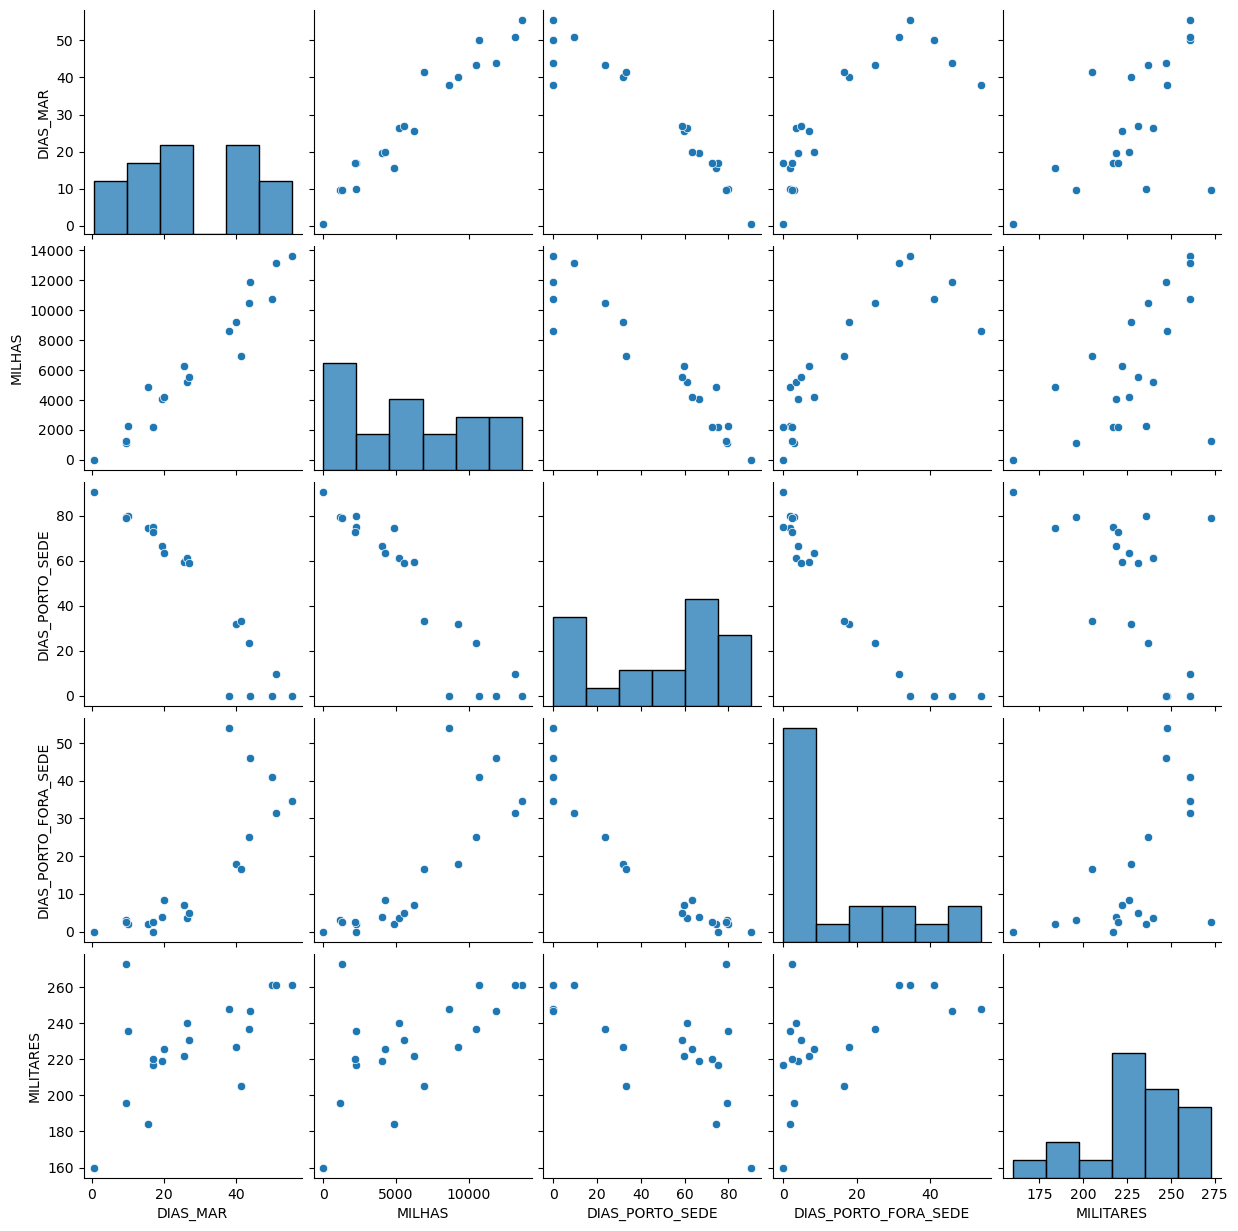

In [49]:
sns.pairplot(df_ATOp[['DIAS_MAR', 'MILHAS', 'DIAS_PORTO_SEDE', 'DIAS_PORTO_FORA_SEDE', 'MILITARES']])

### **Data Preparation**

<Axes: ylabel='DIAS_MAR'>

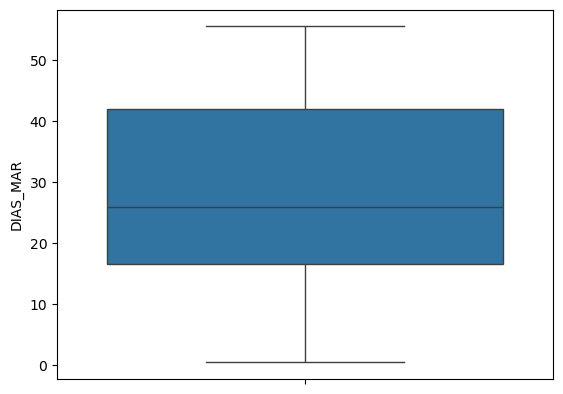

In [50]:
sns.boxplot(df_ATOp['DIAS_MAR'])

In [51]:
## specify phi relevance values
rg_mtrx_iblr = [

    [42,  1, 0],  ## over-sample ("minority")
    [30, 0, 0],  ## under-sample ("majority")
    [20, 0, 0],  ## under-sample
    [31, 0, 0],  ## under-sample
]

In [52]:
## conduct Random Over-sampling

df_ATOp_RO = iblr.gn(
    data = df_ATOp, ## pandas dataframe
    y = 'DIAS_MAR',            ## string ('header name')
    pert = 0.02,              ## perturbation / noise percentage (pos real) #gaussian
    samp_method = 'extreme',   ## string ('balance' or 'extreme')
    drop_na_col = True,        ## boolean (True or False)
    drop_na_row = True,        ## boolean (True or False)
    replace = True,           ## boolean (True or False)
    manual_perc = True,      ## user defines percentage of under-sampling and over-sampling  # added
    perc_u = 0.9,              ## percentage of under-sampling  # added
    perc_o = 100,              ## percentage of over-sampling  # added

    ## phi relevance arguments
    rel_thres = 0.8,               ## real number (0 < R < 1)
    rel_method = 'manual',         ## string ('auto' or 'manual')
    # rel_xtrm_type = 'both',      ## unused (rel_method = 'manual')
    # rel_coef = 1.50,             ## unused (rel_method = 'manual')
    rel_ctrl_pts_rg = rg_mtrx_iblr ## 2d array (format: [x, y])
)


synth_matrix: 100%|##########| 5/5 [00:04<00:00,  1.13it/s]


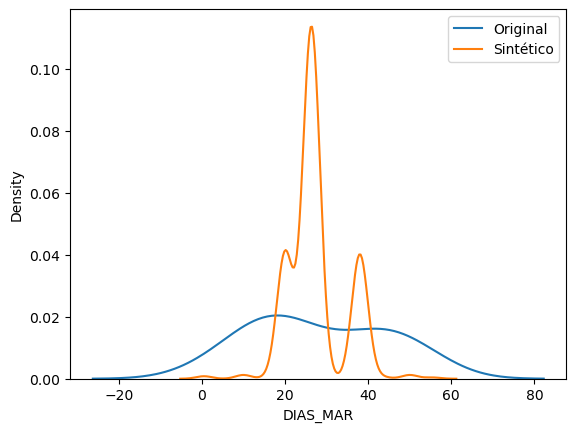

In [53]:
## plot y distribution

sns.kdeplot(df_ATOp['DIAS_MAR'], label = 'Original')
sns.kdeplot(df_ATOp_RO['DIAS_MAR'], label = 'Sintético')
plt.legend(labels=['Original','Sintético'])


<Axes: ylabel='DIAS_MAR'>

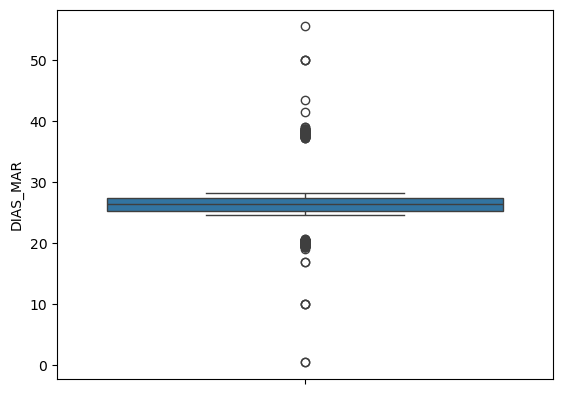

In [54]:
sns.boxplot(df_ATOp_RO['DIAS_MAR'])

In [55]:
# Prepare the data

# Target attribute
# original dataset
y = df_ATOp['DIAS_MAR']
# synthetic data
y_s = df_ATOp_RO['DIAS_MAR']

# Predictive attributes except dropped columns
# original dataset
X = df_ATOp.drop(['ANO', 'TRIMESTRE', 'MILHAS', 'DIAS_MAR'], axis=1)
# synthetic data
X_s = df_ATOp_RO.drop(['ANO', 'TRIMESTRE', 'MILHAS', 'DIAS_MAR'], axis=1)

In [56]:
# Evaluation measures
def metricas(y_treino, predicoes_treino, y_teste, predicoes_teste):
    #r2 = (r2_score(y_teste, predicoes_teste)*100)
    r2 = r2_score(y_teste, predicoes_teste)
    rmse = np.sqrt(mean_squared_error(y_teste, predicoes_teste))
    #mae = mean_absolute_error(y_teste, predicoes_teste)
    #print(f'Coeficiente de Determinação (R²): {r2:.2f}%')
    print(f'Coeficiente de Determinação (R²): {r2:.2f}')
    #print(f'Erro Absoluto Médio (MAE): {mae:.0f}')
    print(f'Raiz do Erro Quadrático Médio (RMSE): {rmse:.2f}')
    print('-'*50)

    plt.scatter(predicoes_treino, y_treino, label='Train Samples', c='#d95f02')
    plt.scatter(predicoes_teste, y_teste, label='Test Samples', c='#7570b3')
    plt.xlabel('Predict Values')
    plt.ylabel('True Values')
    plt.legend()
    plt.plot([0, 50], [0, 50], c="g", zorder=0)  # linha diagonal cor verde
    plt.xlim([0, 50])
    plt.ylim([0, 50])
    plt.tight_layout()
    plt.show()

## **Training, Testing, and Validation**

In [57]:
# Parâmetros globais
N_SPLITS = 5
RANDOM_STATE=0
KF = KFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_STATE)
N_TRIALS=50
N_RUNS=5

### **Modelos Individuais**

In [88]:
# Função unificada de otimização de hiperparâmetros com Optuna
def otimizar_modelos_individuais(model_name, X_train, y_train):
    def objective(trial):
        if model_name == "LinearRegression":
            model = LinearRegression()

        elif model_name == "DecisionTree":
            params = {
                'max_depth': trial.suggest_int('max_depth', 3, 10),
                'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
                'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 5)
            }
            model = DecisionTreeRegressor(**params, random_state=RANDOM_STATE)

        elif model_name == "RandomForest":
            params = {
                'n_estimators': trial.suggest_int('n_estimators', 50, 150),
                'max_depth': trial.suggest_int('max_depth', 3, 10),
                'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
                'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 5)
            }
            model = RandomForestRegressor(**params, random_state=RANDOM_STATE)

        elif model_name == "GradientBoosting":
            params = {
                'n_estimators': trial.suggest_int('n_estimators', 100, 200),
                'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
                'max_depth': trial.suggest_int('max_depth', 3, 10)
            }
            model = GradientBoostingRegressor(**params, random_state=RANDOM_STATE)

        elif model_name == "KNeighbors":
            params = {
                'n_neighbors': trial.suggest_int('n_neighbors', 1, 10),
                'weights': trial.suggest_categorical('weights', ['uniform', 'distance'])
            }
            model = KNeighborsRegressor(**params)

        else:
            raise ValueError(f"Modelo desconhecido: {model_name}")

        return cross_val_score(model, X_train, y_train, cv=KF, scoring='r2', n_jobs=-1).mean()

    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=N_TRIALS, n_jobs=-1)

    return study.best_params, study

# Execução do Pipeline de otimização dos modelos
def executar_pipeline_modelos_individuais(X, y, model_names=None):

    if model_names is None:
        model_names = ["LinearRegression", "DecisionTree", "RandomForest", "GradientBoosting", "KNeighbors"]

    models_params = {}
    study_results = {}
    tempos_execucao_total = {}

    for name in model_names:
        print(f"\nOtimizando modelo: {name}")
        inicio = time.perf_counter()

        # Tempo de otimização com Optuna
        params, study = otimizar_modelos_individuais(name, X, y)
        models_params[name] = params
        study_results[name] = study

        # Tempo de avaliação com melhores hiperparâmetros
        if name == "LinearRegression":
            modelo = make_pipeline(StandardScaler(), LinearRegression())
        elif name == "DecisionTree":
            modelo = DecisionTreeRegressor(random_state=RANDOM_STATE, **params)
        elif name == "RandomForest":
            modelo = RandomForestRegressor(random_state=RANDOM_STATE, **params)
        elif name == "GradientBoosting":
            modelo = GradientBoostingRegressor(random_state=RANDOM_STATE, **params)
        elif name == "KNeighbors":
            modelo = make_pipeline(StandardScaler(), KNeighborsRegressor(**params))
        else:
            raise ValueError(f"Modelo desconhecido: {name}")

        # Avaliação final
        r2_scores = cross_val_score(modelo, X, y, cv=KF, scoring='r2', n_jobs=-1)
        rmse_scores = np.sqrt(-cross_val_score(modelo, X, y, cv=KF, scoring='neg_mean_squared_error', n_jobs=-1))

        fim = time.perf_counter()
        tempo_total = fim - inicio
        tempos_execucao_total[name] = tempo_total

        # Armazenando os resultados
        models_params[name]["R2 Média"] = np.mean(r2_scores)
        models_params[name]["R2 Std"] = np.std(r2_scores)
        models_params[name]["RMSE Média"] = np.mean(rmse_scores)
        models_params[name]["RMSE Std"] = np.std(rmse_scores)

    # Exibindo resultados
    print("Melhores hiperparâmetros encontrados:")
    for model, study in study_results.items():
        print(f"{model}: {study.best_params}")
    print("\nResultados e Tempos de Treinamento:")
    for name in model_names:
        print(f"\n{name}")
        print(f"Tempo Total: {tempos_execucao_total[name]:.2f} segundos")
        print(f"Média do R²: {models_params[name]['R2 Média']:.4f} ± {models_params[name]['R2 Std']:.4f}")
        print(f"Média do RMSE: {models_params[name]['RMSE Média']:.4f} ± {models_params[name]['RMSE Std']:.4f}")

    #return models_params, study_results, tempos_execucao_total

In [89]:
# Execução com Dataset Original
executar_pipeline_modelos_individuais(X, y)

# Execução com Dataset Sintético
# executar_pipeline_modelos_individuais(X_s, y_s)

[I 2025-04-13 23:31:12,984] A new study created in memory with name: no-name-90f701f4-13f6-4123-805f-92514e7f73c6



Otimizando modelo: LinearRegression


[I 2025-04-13 23:31:15,509] Trial 0 finished with value: -0.10109199002519505 and parameters: {}. Best is trial 0 with value: -0.10109199002519505.
[I 2025-04-13 23:31:15,515] Trial 1 finished with value: -0.10109199002519505 and parameters: {}. Best is trial 0 with value: -0.10109199002519505.
[I 2025-04-13 23:31:15,563] Trial 2 finished with value: -0.10109199002519505 and parameters: {}. Best is trial 0 with value: -0.10109199002519505.
[I 2025-04-13 23:31:15,569] Trial 14 finished with value: -0.10109199002519505 and parameters: {}. Best is trial 0 with value: -0.10109199002519505.
[I 2025-04-13 23:31:15,569] Trial 4 finished with value: -0.10109199002519505 and parameters: {}. Best is trial 0 with value: -0.10109199002519505.
[I 2025-04-13 23:31:15,571] Trial 7 finished with value: -0.10109199002519505 and parameters: {}. Best is trial 0 with value: -0.10109199002519505.
[I 2025-04-13 23:31:15,572] Trial 8 finished with value: -0.10109199002519505 and parameters: {}. Best is trial


Otimizando modelo: DecisionTree


[I 2025-04-13 23:31:16,602] Trial 2 finished with value: 0.7199534757221813 and parameters: {'max_depth': 3, 'min_samples_split': 7, 'min_samples_leaf': 4}. Best is trial 2 with value: 0.7199534757221813.
[I 2025-04-13 23:31:16,609] Trial 0 finished with value: 0.7199534757221813 and parameters: {'max_depth': 9, 'min_samples_split': 3, 'min_samples_leaf': 4}. Best is trial 2 with value: 0.7199534757221813.
[I 2025-04-13 23:31:16,685] Trial 4 finished with value: 0.801650959340227 and parameters: {'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 3}. Best is trial 4 with value: 0.801650959340227.
[I 2025-04-13 23:31:16,757] Trial 5 finished with value: 0.7199534757221813 and parameters: {'max_depth': 7, 'min_samples_split': 5, 'min_samples_leaf': 4}. Best is trial 4 with value: 0.801650959340227.
[I 2025-04-13 23:31:16,766] Trial 3 finished with value: 0.801650959340227 and parameters: {'max_depth': 5, 'min_samples_split': 5, 'min_samples_leaf': 3}. Best is trial 4 with value:


Otimizando modelo: RandomForest


[I 2025-04-13 23:31:18,797] Trial 2 finished with value: 0.6123894664410986 and parameters: {'n_estimators': 71, 'max_depth': 8, 'min_samples_split': 6, 'min_samples_leaf': 5}. Best is trial 2 with value: 0.6123894664410986.
[I 2025-04-13 23:31:18,910] Trial 5 finished with value: 0.7289606458492403 and parameters: {'n_estimators': 55, 'max_depth': 9, 'min_samples_split': 6, 'min_samples_leaf': 4}. Best is trial 5 with value: 0.7289606458492403.
[I 2025-04-13 23:31:18,915] Trial 4 finished with value: 0.7868571587096882 and parameters: {'n_estimators': 84, 'max_depth': 5, 'min_samples_split': 3, 'min_samples_leaf': 2}. Best is trial 4 with value: 0.7868571587096882.
[I 2025-04-13 23:31:18,938] Trial 1 finished with value: 0.7766056802769492 and parameters: {'n_estimators': 119, 'max_depth': 9, 'min_samples_split': 6, 'min_samples_leaf': 3}. Best is trial 4 with value: 0.7868571587096882.
[I 2025-04-13 23:31:18,997] Trial 3 finished with value: 0.7868046365718308 and parameters: {'n_est


Otimizando modelo: GradientBoosting


[I 2025-04-13 23:31:24,881] Trial 0 finished with value: 0.8000599699607494 and parameters: {'n_estimators': 102, 'learning_rate': 0.038182273687732596, 'max_depth': 9}. Best is trial 0 with value: 0.8000599699607494.
[I 2025-04-13 23:31:25,050] Trial 1 finished with value: 0.8020387693721197 and parameters: {'n_estimators': 175, 'learning_rate': 0.028865219695760405, 'max_depth': 5}. Best is trial 1 with value: 0.8020387693721197.
[I 2025-04-13 23:31:25,102] Trial 3 finished with value: 0.779296091172179 and parameters: {'n_estimators': 173, 'learning_rate': 0.12081168566140438, 'max_depth': 4}. Best is trial 1 with value: 0.8020387693721197.
[I 2025-04-13 23:31:25,320] Trial 2 finished with value: 0.7837714107540347 and parameters: {'n_estimators': 162, 'learning_rate': 0.14936415128268907, 'max_depth': 4}. Best is trial 1 with value: 0.8020387693721197.
[I 2025-04-13 23:31:25,513] Trial 5 finished with value: 0.8082433669743281 and parameters: {'n_estimators': 154, 'learning_rate': 


Otimizando modelo: KNeighbors


[I 2025-04-13 23:31:32,533] Trial 4 finished with value: -0.645610478995448 and parameters: {'n_neighbors': 10, 'weights': 'distance'}. Best is trial 4 with value: -0.645610478995448.
[I 2025-04-13 23:31:32,582] Trial 5 finished with value: -1.5107220661893783 and parameters: {'n_neighbors': 1, 'weights': 'uniform'}. Best is trial 4 with value: -0.645610478995448.
[I 2025-04-13 23:31:32,807] Trial 6 finished with value: -1.5867178023955621 and parameters: {'n_neighbors': 2, 'weights': 'uniform'}. Best is trial 4 with value: -0.645610478995448.
[I 2025-04-13 23:31:32,850] Trial 0 finished with value: -1.5107220661893783 and parameters: {'n_neighbors': 1, 'weights': 'uniform'}. Best is trial 4 with value: -0.645610478995448.
[I 2025-04-13 23:31:32,868] Trial 8 finished with value: -0.7278400479623667 and parameters: {'n_neighbors': 4, 'weights': 'uniform'}. Best is trial 4 with value: -0.645610478995448.
[I 2025-04-13 23:31:32,928] Trial 7 finished with value: -1.5867178023955621 and par

Melhores hiperparâmetros encontrados:
LinearRegression: {}
DecisionTree: {'max_depth': 10, 'min_samples_split': 5, 'min_samples_leaf': 2}
RandomForest: {'n_estimators': 108, 'max_depth': 7, 'min_samples_split': 4, 'min_samples_leaf': 1}
GradientBoosting: {'n_estimators': 134, 'learning_rate': 0.08219636320888524, 'max_depth': 3}
KNeighbors: {'n_neighbors': 9, 'weights': 'uniform'}

Resultados e Tempos de Treinamento:

LinearRegression
Tempo Total: 3.40 segundos
Média do R²: 0.6225 ± 0.3355
Média do RMSE: 7.9521 ± 5.7818

DecisionTree
Tempo Total: 2.10 segundos
Média do R²: 0.8188 ± 0.1116
Média do RMSE: 5.6674 ± 2.1063

RandomForest
Tempo Total: 5.94 segundos
Média do R²: 0.8004 ± 0.0635
Média do RMSE: 6.2467 ± 1.9774

GradientBoosting
Tempo Total: 6.93 segundos
Média do R²: 0.8868 ± 0.0726
Média do RMSE: 4.5953 ± 1.8985

KNeighbors
Tempo Total: 2.85 segundos
Média do R²: -0.0899 ± 0.3403
Média do RMSE: 14.4341 ± 4.0622


In [90]:
# Execução com Dataset Sintético
executar_pipeline_modelos_individuais(X_s, y_s)

[I 2025-04-13 23:40:42,140] A new study created in memory with name: no-name-541e0912-dbb6-41a3-9206-5fa85c786e6d



Otimizando modelo: LinearRegression


[I 2025-04-13 23:40:42,545] Trial 3 finished with value: 0.9252638801234019 and parameters: {}. Best is trial 3 with value: 0.9252638801234019.
[I 2025-04-13 23:40:42,649] Trial 0 finished with value: 0.9252638801234019 and parameters: {}. Best is trial 3 with value: 0.9252638801234019.
[I 2025-04-13 23:40:42,779] Trial 8 finished with value: 0.9252638801234019 and parameters: {}. Best is trial 3 with value: 0.9252638801234019.
[I 2025-04-13 23:40:42,802] Trial 15 finished with value: 0.9252638801234019 and parameters: {}. Best is trial 3 with value: 0.9252638801234019.
[I 2025-04-13 23:40:42,841] Trial 9 finished with value: 0.9252638801234019 and parameters: {}. Best is trial 3 with value: 0.9252638801234019.
[I 2025-04-13 23:40:42,865] Trial 7 finished with value: 0.9252638801234019 and parameters: {}. Best is trial 3 with value: 0.9252638801234019.
[I 2025-04-13 23:40:43,003] Trial 16 finished with value: 0.9252638801234019 and parameters: {}. Best is trial 3 with value: 0.92526388


Otimizando modelo: DecisionTree


[I 2025-04-13 23:40:45,407] Trial 0 finished with value: 0.9604416813402062 and parameters: {'max_depth': 4, 'min_samples_split': 8, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.9604416813402062.
[I 2025-04-13 23:40:45,517] Trial 1 finished with value: 0.9592702330837763 and parameters: {'max_depth': 7, 'min_samples_split': 3, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.9604416813402062.
[I 2025-04-13 23:40:45,571] Trial 4 finished with value: 0.9360297484375539 and parameters: {'max_depth': 5, 'min_samples_split': 3, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.9604416813402062.
[I 2025-04-13 23:40:45,575] Trial 3 finished with value: 0.9394343480659296 and parameters: {'max_depth': 10, 'min_samples_split': 4, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.9604416813402062.
[I 2025-04-13 23:40:45,611] Trial 5 finished with value: 0.9395531689316561 and parameters: {'max_depth': 3, 'min_samples_split': 9, 'min_samples_leaf': 5}. Best is trial 0 with v


Otimizando modelo: RandomForest


[I 2025-04-13 23:40:47,815] Trial 1 finished with value: 0.9672849015433431 and parameters: {'n_estimators': 94, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 1}. Best is trial 1 with value: 0.9672849015433431.
[I 2025-04-13 23:40:48,042] Trial 0 finished with value: 0.943004464553525 and parameters: {'n_estimators': 80, 'max_depth': 5, 'min_samples_split': 4, 'min_samples_leaf': 5}. Best is trial 1 with value: 0.9672849015433431.
[I 2025-04-13 23:40:48,238] Trial 3 finished with value: 0.9512738812925801 and parameters: {'n_estimators': 101, 'max_depth': 6, 'min_samples_split': 6, 'min_samples_leaf': 4}. Best is trial 1 with value: 0.9672849015433431.
[I 2025-04-13 23:40:48,430] Trial 6 finished with value: 0.9511787464562564 and parameters: {'n_estimators': 81, 'max_depth': 6, 'min_samples_split': 8, 'min_samples_leaf': 4}. Best is trial 1 with value: 0.9672849015433431.
[I 2025-04-13 23:40:48,475] Trial 2 finished with value: 0.9509453105966289 and parameters: {'n_est


Otimizando modelo: GradientBoosting


[I 2025-04-13 23:41:08,750] Trial 0 finished with value: 0.9776440095444305 and parameters: {'n_estimators': 131, 'learning_rate': 0.043495221783095755, 'max_depth': 10}. Best is trial 0 with value: 0.9776440095444305.
[I 2025-04-13 23:41:14,156] Trial 1 finished with value: 0.9771566697276647 and parameters: {'n_estimators': 198, 'learning_rate': 0.13525920070255645, 'max_depth': 8}. Best is trial 0 with value: 0.9776440095444305.
[I 2025-04-13 23:41:14,176] Trial 5 finished with value: 0.9730138226531524 and parameters: {'n_estimators': 152, 'learning_rate': 0.05497212862095116, 'max_depth': 3}. Best is trial 0 with value: 0.9776440095444305.
[I 2025-04-13 23:41:14,243] Trial 8 finished with value: 0.979420874396903 and parameters: {'n_estimators': 135, 'learning_rate': 0.18621796970209514, 'max_depth': 3}. Best is trial 8 with value: 0.979420874396903.
[I 2025-04-13 23:41:15,419] Trial 6 finished with value: 0.9763357013097191 and parameters: {'n_estimators': 127, 'learning_rate': 0


Otimizando modelo: KNeighbors


[I 2025-04-13 23:41:55,818] Trial 6 finished with value: 0.8673174379815766 and parameters: {'n_neighbors': 7, 'weights': 'uniform'}. Best is trial 6 with value: 0.8673174379815766.
[I 2025-04-13 23:41:55,862] Trial 4 finished with value: 0.9595789471462876 and parameters: {'n_neighbors': 2, 'weights': 'distance'}. Best is trial 4 with value: 0.9595789471462876.
[I 2025-04-13 23:41:55,915] Trial 5 finished with value: 0.9686726360040229 and parameters: {'n_neighbors': 5, 'weights': 'distance'}. Best is trial 5 with value: 0.9686726360040229.
[I 2025-04-13 23:41:55,965] Trial 7 finished with value: 0.9231002480205597 and parameters: {'n_neighbors': 1, 'weights': 'distance'}. Best is trial 5 with value: 0.9686726360040229.
[I 2025-04-13 23:41:56,023] Trial 8 finished with value: 0.9231002480205597 and parameters: {'n_neighbors': 1, 'weights': 'distance'}. Best is trial 5 with value: 0.9686726360040229.
[I 2025-04-13 23:41:56,070] Trial 10 finished with value: 0.9335118813677992 and param

Melhores hiperparâmetros encontrados:
LinearRegression: {}
DecisionTree: {'max_depth': 3, 'min_samples_split': 6, 'min_samples_leaf': 2}
RandomForest: {'n_estimators': 127, 'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 1}
GradientBoosting: {'n_estimators': 186, 'learning_rate': 0.15683710072949297, 'max_depth': 5}
KNeighbors: {'n_neighbors': 4, 'weights': 'distance'}

Resultados e Tempos de Treinamento:

LinearRegression
Tempo Total: 3.00 segundos
Média do R²: 0.9253 ± 0.1294
Média do RMSE: 1.3357 ± 1.4047

DecisionTree
Tempo Total: 2.18 segundos
Média do R²: 0.9626 ± 0.0490
Média do RMSE: 1.1094 ± 0.7719

RandomForest
Tempo Total: 17.34 segundos
Média do R²: 0.9725 ± 0.0371
Média do RMSE: 0.9348 ± 0.6850

GradientBoosting
Tempo Total: 50.88 segundos
Média do R²: 0.9807 ± 0.0231
Média do RMSE: 0.7981 ± 0.5317

KNeighbors
Tempo Total: 2.00 segundos
Média do R²: 0.9728 ± 0.0430
Média do RMSE: 0.8516 ± 0.7917


### **Comitê de Modelos**

In [95]:
# ========================
# Classe ComiteModelos
# ========================
class ComiteModelos(BaseEstimator, RegressorMixin):
    def __init__(self, model_names=("Random Forest", "Gradient Boosting"),
                 model_params=None, n_runs=N_RUNS, random_state=None):
        self.model_names = model_names
        self.model_params = model_params or {}
        self.n_runs = n_runs
        self.random_state = random_state

    def _get_model(self, name):
        params = self.model_params.get(name, {})
        if name == "Linear Regression":
            return LinearRegression(**params)
        elif name == "Decision Tree":
            return DecisionTreeRegressor(**params)
        elif name == "Random Forest":
            return RandomForestRegressor(**params)
        elif name == "Gradient Boosting":
            return GradientBoostingRegressor(**params)
        elif name == "K-Nearest Neighbors":
            return KNeighborsRegressor(**params)
        else:
            raise ValueError(f"Modelo desconhecido: {name}")

    def fit(self, X, y):
        self.ensembles_ = []
        self.cols_used_ = []
        rng = np.random.RandomState(self.random_state)
        name1, name2 = self.model_names
        all_cols = list(X.columns)

        for _ in range(self.n_runs):
            rng.shuffle(all_cols)
            mid = len(all_cols) // 2
            cols1 = all_cols[:mid]
            cols2 = all_cols[mid:]

            self.cols_used_.append((cols1.copy(), cols2.copy()))

            model1 = self._get_model(name1)
            model2 = self._get_model(name2)

            model1.fit(X[cols1], y)
            model2.fit(X[cols2], y)

            ensemble = VotingRegressor([
                ('model1', model1),
                ('model2', model2)
            ])
            ensemble.fit(X[cols1 + cols2], y)
            self.ensembles_.append((ensemble, cols1.copy(), cols2.copy()))

        return self

    def predict(self, X):
        preds = []
        for ensemble, cols1, cols2 in self.ensembles_:
            X_used = X[cols1 + cols2].copy()
            preds.append(ensemble.predict(X_used))
        return np.mean(preds, axis=0)

# =========================
# Funções auxiliares Optuna
# =========================
def suggest_params(trial, model_name, prefix=""):
    if model_name == "Decision Tree":
        return {
            'max_depth': trial.suggest_int(f'{prefix}max_depth', 3, 10),
            'min_samples_split': trial.suggest_int(f'{prefix}min_samples_split', 2, 10),
            'min_samples_leaf': trial.suggest_int(f'{prefix}min_samples_leaf', 1, 5)
        }
    elif model_name == "Random Forest":
        return {
            'n_estimators': trial.suggest_int(f'{prefix}n_estimators', 50, 150),
            'max_depth': trial.suggest_int(f'{prefix}max_depth', 3, 10),
            'min_samples_split': trial.suggest_int(f'{prefix}min_samples_split', 2, 10),
            'min_samples_leaf': trial.suggest_int(f'{prefix}min_samples_leaf', 1, 5)
        }
    elif model_name == "Gradient Boosting":
        return {
            'n_estimators': trial.suggest_int(f'{prefix}n_estimators', 100, 200),
            'learning_rate': trial.suggest_float(f'{prefix}learning_rate', 0.01, 0.2),
            'max_depth': trial.suggest_int(f'{prefix}max_depth', 3, 10)
        }
    elif model_name == "K-Nearest Neighbors":
        return {
            'n_neighbors': trial.suggest_int(f'{prefix}n_neighbors', 1, 10),
            'weights': trial.suggest_categorical(f'{prefix}weights', ['uniform', 'distance'])
        }
    elif model_name == "Linear Regression":
        return {}
    else:
        raise ValueError(f"Modelo desconhecido: {model_name}")

def extract_params(params_dict, prefix):
    return {k.replace(prefix, ""): v for k, v in params_dict.items() if k.startswith(prefix)}

# ========================================
# Otimização de hiperparâmetros com Optuna
# ========================================
def optimize_pair_model_random_split(name1, name2, X, y, n_splits=N_SPLITS, n_trials=N_TRIALS, n_runs=N_RUNS, random_state=RANDOM_STATE):
    def objective(trial):
        params = {
            name1: suggest_params(trial, name1, prefix="m1_"),
            name2: suggest_params(trial, name2, prefix="m2_")
        }

        model = ComiteModelos(
            model_names=(name1, name2),
            model_params=params,
            n_runs=n_runs,
            random_state=random_state
        )

        scores = []
        for train_idx, val_idx in KF.split(X):
            model.fit(X.iloc[train_idx], y.iloc[train_idx])
            pred = model.predict(X.iloc[val_idx])
            scores.append(r2_score(y.iloc[val_idx], pred))

        return np.mean(scores)

    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=n_trials)

    best_params = {
        name1: extract_params(study.best_params, "m1_"),
        name2: extract_params(study.best_params, "m2_")
    }

    return best_params, study

# ========================
# Pipeline final de execução
# ========================
def executar_pipeline_comite_colunas_aleatorias(X, y, n_trials=N_TRIALS, n_splits=N_SPLITS, n_runs=N_RUNS):
    results = {}
    model_names = [
        "Linear Regression",
        "Decision Tree",
        "Random Forest",
        "Gradient Boosting",
        "K-Nearest Neighbors"
    ]

    for name1, name2 in combinations(model_names, 2):
        print(f"\n Otimizando par com colunas aleatórias por execução: {name1} + {name2}")

        # Cronômetro da otimização
        inicio_otimizacao = time.perf_counter()
        best_params, _ = optimize_pair_model_random_split(
            name1, name2, X, y,
            n_splits=n_splits,
            n_trials=n_trials,
            n_runs=n_runs,
            random_state=RANDOM_STATE
        )
        fim_otimizacao = time.perf_counter()
        tempo_otimizacao = fim_otimizacao - inicio_otimizacao

        # Cronômetro da avaliação
        inicio_avaliacao = time.perf_counter()
        model = ComiteModelos(
            model_names=(name1, name2),
            model_params=best_params,
            n_runs=n_runs,
            random_state=RANDOM_STATE
        )

        r2_scores = []
        rmse_scores = []
        for train_idx, test_idx in KF.split(X):
            model.fit(X.iloc[train_idx], y.iloc[train_idx])
            pred = model.predict(X.iloc[test_idx])
            r2_scores.append(r2_score(y.iloc[test_idx], pred))
            rmse_scores.append(root_mean_squared_error(y.iloc[test_idx], pred))
        fim_avaliacao = time.perf_counter()
        tempo_avaliacao = fim_avaliacao - inicio_avaliacao

        tempo_total = tempo_otimizacao + tempo_avaliacao

        results[f"{name1} + {name2}"] = {
            "R2 Média": np.mean(r2_scores),
            "R2 Std": np.std(r2_scores),
            "RMSE Média": np.mean(rmse_scores),
            "RMSE Std": np.std(rmse_scores),
            "Tempo Total (s)": tempo_total
        }

    df_results = pd.DataFrame(results).T.sort_values("R2 Média", ascending=False)
    print("\n Resultados por Par de Modelos com Colunas Aleatórias com 5 Execuções:")
    print(df_results.round(4))
    return df_results

In [96]:
# Execução com Dataset Original
executar_pipeline_comite_colunas_aleatorias(X, y)

# Execução com Dataset Sintético
# executar_pipeline_comite_colunas_aleatorias(X_s, y_s)

[I 2025-04-14 00:35:11,763] A new study created in memory with name: no-name-fc2c4610-5d7e-4102-ad89-c1340411de6d



 Otimizando par com colunas aleatórias por execução: Linear Regression + Decision Tree


[I 2025-04-14 00:35:12,241] Trial 0 finished with value: 0.5840767274020735 and parameters: {'m2_max_depth': 9, 'm2_min_samples_split': 10, 'm2_min_samples_leaf': 2}. Best is trial 0 with value: 0.5840767274020735.
[I 2025-04-14 00:35:12,685] Trial 1 finished with value: 0.5840767274020735 and parameters: {'m2_max_depth': 5, 'm2_min_samples_split': 10, 'm2_min_samples_leaf': 1}. Best is trial 0 with value: 0.5840767274020735.
[I 2025-04-14 00:35:13,038] Trial 2 finished with value: 0.6200628949332521 and parameters: {'m2_max_depth': 10, 'm2_min_samples_split': 5, 'm2_min_samples_leaf': 2}. Best is trial 2 with value: 0.6200628949332521.
[I 2025-04-14 00:35:13,383] Trial 3 finished with value: 0.5967944837997475 and parameters: {'m2_max_depth': 8, 'm2_min_samples_split': 5, 'm2_min_samples_leaf': 3}. Best is trial 2 with value: 0.6200628949332521.
[I 2025-04-14 00:35:13,734] Trial 4 finished with value: 0.607764482879821 and parameters: {'m2_max_depth': 9, 'm2_min_samples_split': 7, 'm2


 Otimizando par com colunas aleatórias por execução: Linear Regression + Random Forest


[I 2025-04-14 00:35:39,573] Trial 0 finished with value: 0.5815091271726223 and parameters: {'m2_n_estimators': 90, 'm2_max_depth': 4, 'm2_min_samples_split': 9, 'm2_min_samples_leaf': 4}. Best is trial 0 with value: 0.5815091271726223.
[I 2025-04-14 00:35:48,455] Trial 1 finished with value: 0.546195944939807 and parameters: {'m2_n_estimators': 104, 'm2_max_depth': 4, 'm2_min_samples_split': 8, 'm2_min_samples_leaf': 5}. Best is trial 0 with value: 0.5815091271726223.
[I 2025-04-14 00:35:54,776] Trial 2 finished with value: 0.568756362818827 and parameters: {'m2_n_estimators': 76, 'm2_max_depth': 6, 'm2_min_samples_split': 10, 'm2_min_samples_leaf': 4}. Best is trial 0 with value: 0.5815091271726223.
[I 2025-04-14 00:36:07,062] Trial 3 finished with value: 0.5876459069748435 and parameters: {'m2_n_estimators': 141, 'm2_max_depth': 7, 'm2_min_samples_split': 6, 'm2_min_samples_leaf': 3}. Best is trial 3 with value: 0.5876459069748435.
[I 2025-04-14 00:36:14,179] Trial 4 finished with v


 Otimizando par com colunas aleatórias por execução: Linear Regression + Gradient Boosting


[I 2025-04-14 00:44:09,431] Trial 0 finished with value: 0.6149032667077613 and parameters: {'m2_n_estimators': 198, 'm2_learning_rate': 0.06625780800497241, 'm2_max_depth': 4}. Best is trial 0 with value: 0.6149032667077613.
[I 2025-04-14 00:44:16,373] Trial 1 finished with value: 0.6111901821460369 and parameters: {'m2_n_estimators': 189, 'm2_learning_rate': 0.19057567748616377, 'm2_max_depth': 9}. Best is trial 0 with value: 0.6149032667077613.
[I 2025-04-14 00:44:23,621] Trial 2 finished with value: 0.6283793576501093 and parameters: {'m2_n_estimators': 191, 'm2_learning_rate': 0.10770711409611157, 'm2_max_depth': 3}. Best is trial 2 with value: 0.6283793576501093.
[I 2025-04-14 00:44:29,893] Trial 3 finished with value: 0.6104605066458813 and parameters: {'m2_n_estimators': 159, 'm2_learning_rate': 0.023034223045703253, 'm2_max_depth': 6}. Best is trial 2 with value: 0.6283793576501093.
[I 2025-04-14 00:44:35,100] Trial 4 finished with value: 0.6101608377841895 and parameters: {'m


 Otimizando par com colunas aleatórias por execução: Linear Regression + K-Nearest Neighbors


[I 2025-04-14 00:50:04,562] Trial 0 finished with value: -0.189119607350783 and parameters: {'m2_n_neighbors': 1, 'm2_weights': 'distance'}. Best is trial 0 with value: -0.189119607350783.
[I 2025-04-14 00:50:05,229] Trial 1 finished with value: 0.2605806226800487 and parameters: {'m2_n_neighbors': 7, 'm2_weights': 'uniform'}. Best is trial 1 with value: 0.2605806226800487.
[I 2025-04-14 00:50:06,080] Trial 2 finished with value: 0.0736582178312736 and parameters: {'m2_n_neighbors': 6, 'm2_weights': 'distance'}. Best is trial 1 with value: 0.2605806226800487.
[I 2025-04-14 00:50:06,773] Trial 3 finished with value: 0.25501444722310396 and parameters: {'m2_n_neighbors': 6, 'm2_weights': 'uniform'}. Best is trial 1 with value: 0.2605806226800487.
[I 2025-04-14 00:50:07,417] Trial 4 finished with value: 0.3074114549098602 and parameters: {'m2_n_neighbors': 9, 'm2_weights': 'uniform'}. Best is trial 4 with value: 0.3074114549098602.
[I 2025-04-14 00:50:08,097] Trial 5 finished with value: 


 Otimizando par com colunas aleatórias por execução: Decision Tree + Random Forest


[I 2025-04-14 00:50:49,187] Trial 0 finished with value: 0.7574436643740683 and parameters: {'m1_max_depth': 10, 'm1_min_samples_split': 5, 'm1_min_samples_leaf': 5, 'm2_n_estimators': 129, 'm2_max_depth': 9, 'm2_min_samples_split': 9, 'm2_min_samples_leaf': 1}. Best is trial 0 with value: 0.7574436643740683.
[I 2025-04-14 00:50:55,351] Trial 1 finished with value: 0.7606183705749843 and parameters: {'m1_max_depth': 6, 'm1_min_samples_split': 10, 'm1_min_samples_leaf': 1, 'm2_n_estimators': 79, 'm2_max_depth': 5, 'm2_min_samples_split': 7, 'm2_min_samples_leaf': 5}. Best is trial 1 with value: 0.7606183705749843.
[I 2025-04-14 00:51:05,572] Trial 2 finished with value: 0.7639860965964329 and parameters: {'m1_max_depth': 6, 'm1_min_samples_split': 10, 'm1_min_samples_leaf': 1, 'm2_n_estimators': 132, 'm2_max_depth': 10, 'm2_min_samples_split': 7, 'm2_min_samples_leaf': 5}. Best is trial 2 with value: 0.7639860965964329.
[I 2025-04-14 00:51:10,682] Trial 3 finished with value: 0.78021479


 Otimizando par com colunas aleatórias por execução: Decision Tree + Gradient Boosting


[I 2025-04-14 00:56:14,132] Trial 0 finished with value: 0.7894408202704534 and parameters: {'m1_max_depth': 7, 'm1_min_samples_split': 2, 'm1_min_samples_leaf': 2, 'm2_n_estimators': 107, 'm2_learning_rate': 0.1981078430379714, 'm2_max_depth': 10}. Best is trial 0 with value: 0.7894408202704534.
[I 2025-04-14 00:56:21,873] Trial 1 finished with value: 0.8100741351272802 and parameters: {'m1_max_depth': 5, 'm1_min_samples_split': 6, 'm1_min_samples_leaf': 3, 'm2_n_estimators': 199, 'm2_learning_rate': 0.14555800945535965, 'm2_max_depth': 7}. Best is trial 1 with value: 0.8100741351272802.
[I 2025-04-14 00:56:27,041] Trial 2 finished with value: 0.8272659018354996 and parameters: {'m1_max_depth': 4, 'm1_min_samples_split': 10, 'm1_min_samples_leaf': 2, 'm2_n_estimators': 130, 'm2_learning_rate': 0.18569708289419953, 'm2_max_depth': 8}. Best is trial 2 with value: 0.8272659018354996.
[I 2025-04-14 00:56:33,234] Trial 3 finished with value: 0.7990130261649633 and parameters: {'m1_max_dept


 Otimizando par com colunas aleatórias por execução: Decision Tree + K-Nearest Neighbors


[I 2025-04-14 01:01:44,716] Trial 0 finished with value: 0.385841398492355 and parameters: {'m1_max_depth': 4, 'm1_min_samples_split': 8, 'm1_min_samples_leaf': 5, 'm2_n_neighbors': 3, 'm2_weights': 'uniform'}. Best is trial 0 with value: 0.385841398492355.
[I 2025-04-14 01:01:45,501] Trial 1 finished with value: 0.4477155118021544 and parameters: {'m1_max_depth': 9, 'm1_min_samples_split': 2, 'm1_min_samples_leaf': 2, 'm2_n_neighbors': 9, 'm2_weights': 'distance'}. Best is trial 1 with value: 0.4477155118021544.
[I 2025-04-14 01:01:46,275] Trial 2 finished with value: 0.25466690287660765 and parameters: {'m1_max_depth': 5, 'm1_min_samples_split': 4, 'm1_min_samples_leaf': 2, 'm2_n_neighbors': 2, 'm2_weights': 'distance'}. Best is trial 1 with value: 0.4477155118021544.
[I 2025-04-14 01:01:46,887] Trial 3 finished with value: 0.5709477845226696 and parameters: {'m1_max_depth': 3, 'm1_min_samples_split': 8, 'm1_min_samples_leaf': 2, 'm2_n_neighbors': 8, 'm2_weights': 'uniform'}. Best is


 Otimizando par com colunas aleatórias por execução: Random Forest + Gradient Boosting


[I 2025-04-14 01:02:27,811] Trial 0 finished with value: 0.8249419105836491 and parameters: {'m1_n_estimators': 62, 'm1_max_depth': 10, 'm1_min_samples_split': 4, 'm1_min_samples_leaf': 4, 'm2_n_estimators': 185, 'm2_learning_rate': 0.060722736566383766, 'm2_max_depth': 4}. Best is trial 0 with value: 0.8249419105836491.
[I 2025-04-14 01:02:40,235] Trial 1 finished with value: 0.7941225933407379 and parameters: {'m1_n_estimators': 84, 'm1_max_depth': 8, 'm1_min_samples_split': 7, 'm1_min_samples_leaf': 5, 'm2_n_estimators': 190, 'm2_learning_rate': 0.1449341582064809, 'm2_max_depth': 6}. Best is trial 0 with value: 0.8249419105836491.
[I 2025-04-14 01:02:49,233] Trial 2 finished with value: 0.8102389149683449 and parameters: {'m1_n_estimators': 69, 'm1_max_depth': 5, 'm1_min_samples_split': 2, 'm1_min_samples_leaf': 3, 'm2_n_estimators': 104, 'm2_learning_rate': 0.014168535016711909, 'm2_max_depth': 8}. Best is trial 0 with value: 0.8249419105836491.
[I 2025-04-14 01:02:59,695] Trial 3


 Otimizando par com colunas aleatórias por execução: Random Forest + K-Nearest Neighbors


[I 2025-04-14 01:13:10,574] Trial 0 finished with value: -0.09506708348510831 and parameters: {'m1_n_estimators': 65, 'm1_max_depth': 7, 'm1_min_samples_split': 9, 'm1_min_samples_leaf': 5, 'm2_n_neighbors': 1, 'm2_weights': 'distance'}. Best is trial 0 with value: -0.09506708348510831.
[I 2025-04-14 01:13:21,485] Trial 1 finished with value: 0.0269298254739327 and parameters: {'m1_n_estimators': 141, 'm1_max_depth': 10, 'm1_min_samples_split': 8, 'm1_min_samples_leaf': 3, 'm2_n_neighbors': 2, 'm2_weights': 'uniform'}. Best is trial 1 with value: 0.0269298254739327.
[I 2025-04-14 01:13:29,516] Trial 2 finished with value: -0.03164754176862481 and parameters: {'m1_n_estimators': 108, 'm1_max_depth': 6, 'm1_min_samples_split': 10, 'm1_min_samples_leaf': 3, 'm2_n_neighbors': 1, 'm2_weights': 'distance'}. Best is trial 1 with value: 0.0269298254739327.
[I 2025-04-14 01:13:39,354] Trial 3 finished with value: -0.09651514418165255 and parameters: {'m1_n_estimators': 128, 'm1_max_depth': 10, 


 Otimizando par com colunas aleatórias por execução: Gradient Boosting + K-Nearest Neighbors


[I 2025-04-14 01:19:22,967] Trial 0 finished with value: 0.3587030847884566 and parameters: {'m1_n_estimators': 152, 'm1_learning_rate': 0.0937592881338101, 'm1_max_depth': 10, 'm2_n_neighbors': 3, 'm2_weights': 'distance'}. Best is trial 0 with value: 0.3587030847884566.
[I 2025-04-14 01:19:28,045] Trial 1 finished with value: 0.5599936411353905 and parameters: {'m1_n_estimators': 124, 'm1_learning_rate': 0.06249323087641015, 'm1_max_depth': 3, 'm2_n_neighbors': 9, 'm2_weights': 'uniform'}. Best is trial 1 with value: 0.5599936411353905.
[I 2025-04-14 01:19:34,998] Trial 2 finished with value: 0.44262861107003887 and parameters: {'m1_n_estimators': 171, 'm1_learning_rate': 0.1564468877090765, 'm1_max_depth': 10, 'm2_n_neighbors': 8, 'm2_weights': 'distance'}. Best is trial 1 with value: 0.5599936411353905.
[I 2025-04-14 01:19:40,334] Trial 3 finished with value: 0.46093206384090113 and parameters: {'m1_n_estimators': 128, 'm1_learning_rate': 0.1319199652252256, 'm1_max_depth': 7, 'm2_


 Resultados por Par de Modelos com Colunas Aleatórias com 5 Execuções:
                                         R2 Média  R2 Std  RMSE Média  \
Decision Tree + Gradient Boosting          0.8651  0.0696      5.0382   
Random Forest + Gradient Boosting          0.8577  0.0848      5.2130   
Decision Tree + Random Forest              0.8307  0.0590      5.7669   
Linear Regression + Decision Tree          0.6403  0.2220      8.3225   
Linear Regression + Gradient Boosting      0.6304  0.2351      8.3976   
Linear Regression + Random Forest          0.6174  0.2627      8.5181   
Decision Tree + K-Nearest Neighbors        0.5962  0.3643      8.5849   
Gradient Boosting + K-Nearest Neighbors    0.5774  0.3528      8.8023   
Random Forest + K-Nearest Neighbors        0.5306  0.3488      9.4645   
Linear Regression + K-Nearest Neighbors    0.3074  0.5135     11.6637   

                                         RMSE Std  Tempo Total (s)  
Decision Tree + Gradient Boosting          1.9078      

,R2 Média,R2 Std,RMSE Média,RMSE Std,Tempo Total (s)
Decision Tree + Gradient Boosting,0.865081,0.069603,5.038217,1.907789,334.376410
Random Forest + Gradient Boosting,0.857674,0.084825,5.213005,2.283807,648.793698
Decision Tree + Random Forest,0.830691,0.059012,5.766850,2.063777,330.682074
Linear Regression + Decision Tree,0.640274,0.222008,8.322489,4.279392,20.571660
Linear Regression + Gradient Boosting,0.630377,0.235052,8.397607,4.551362,362.282838
Linear Regression + Random Forest,0.617397,0.262663,8.518112,4.832639,509.231018
Decision Tree + K-Nearest Neighbors,0.596160,0.364333,8.584908,5.537772,32.477757
Gradient Boosting + K-Nearest Neighbors,0.577444,0.352818,8.802279,5.279952,302.928473
Random Forest + K-Nearest Neighbors,0.530640,0.348756,9.464473,5.377959,371.275083
Linear Regression + K-Nearest Neighbors,0.307411,0.513497,11.663730,7.109624,35.231038


In [97]:
# Execução com Dataset Sintético
executar_pipeline_comite_colunas_aleatorias(X_s, y_s)

[I 2025-04-14 01:24:19,647] A new study created in memory with name: no-name-3a25ed33-928b-47c4-a51a-9eb8c1453ba5



 Otimizando par com colunas aleatórias por execução: Linear Regression + Decision Tree


[I 2025-04-14 01:24:20,328] Trial 0 finished with value: 0.9446926853253 and parameters: {'m2_max_depth': 4, 'm2_min_samples_split': 5, 'm2_min_samples_leaf': 5}. Best is trial 0 with value: 0.9446926853253.
[I 2025-04-14 01:24:21,038] Trial 1 finished with value: 0.9492533816496532 and parameters: {'m2_max_depth': 6, 'm2_min_samples_split': 10, 'm2_min_samples_leaf': 1}. Best is trial 1 with value: 0.9492533816496532.
[I 2025-04-14 01:24:21,537] Trial 2 finished with value: 0.9477469488156787 and parameters: {'m2_max_depth': 3, 'm2_min_samples_split': 5, 'm2_min_samples_leaf': 5}. Best is trial 1 with value: 0.9492533816496532.
[I 2025-04-14 01:24:22,173] Trial 3 finished with value: 0.9515135881205167 and parameters: {'m2_max_depth': 6, 'm2_min_samples_split': 9, 'm2_min_samples_leaf': 3}. Best is trial 3 with value: 0.9515135881205167.
[I 2025-04-14 01:24:22,715] Trial 4 finished with value: 0.9457544706501567 and parameters: {'m2_max_depth': 4, 'm2_min_samples_split': 9, 'm2_min_sa


 Otimizando par com colunas aleatórias por execução: Linear Regression + Random Forest


[I 2025-04-14 01:25:22,702] Trial 0 finished with value: 0.9569607190008954 and parameters: {'m2_n_estimators': 114, 'm2_max_depth': 7, 'm2_min_samples_split': 9, 'm2_min_samples_leaf': 2}. Best is trial 0 with value: 0.9569607190008954.
[I 2025-04-14 01:25:35,311] Trial 1 finished with value: 0.9576352935708222 and parameters: {'m2_n_estimators': 77, 'm2_max_depth': 3, 'm2_min_samples_split': 3, 'm2_min_samples_leaf': 1}. Best is trial 1 with value: 0.9576352935708222.
[I 2025-04-14 01:25:52,077] Trial 2 finished with value: 0.9564746157060794 and parameters: {'m2_n_estimators': 60, 'm2_max_depth': 8, 'm2_min_samples_split': 4, 'm2_min_samples_leaf': 2}. Best is trial 1 with value: 0.9576352935708222.
[I 2025-04-14 01:26:10,454] Trial 3 finished with value: 0.9513193914831575 and parameters: {'m2_n_estimators': 117, 'm2_max_depth': 3, 'm2_min_samples_split': 7, 'm2_min_samples_leaf': 4}. Best is trial 1 with value: 0.9576352935708222.
[I 2025-04-14 01:26:28,889] Trial 4 finished with 


 Otimizando par com colunas aleatórias por execução: Linear Regression + Gradient Boosting


[I 2025-04-14 01:44:29,518] Trial 0 finished with value: 0.9616055829920732 and parameters: {'m2_n_estimators': 117, 'm2_learning_rate': 0.03792215313317254, 'm2_max_depth': 5}. Best is trial 0 with value: 0.9616055829920732.
[I 2025-04-14 01:45:10,771] Trial 1 finished with value: 0.96064686901669 and parameters: {'m2_n_estimators': 185, 'm2_learning_rate': 0.1805899198038545, 'm2_max_depth': 4}. Best is trial 0 with value: 0.9616055829920732.
[I 2025-04-14 01:45:56,323] Trial 2 finished with value: 0.9590200813141386 and parameters: {'m2_n_estimators': 148, 'm2_learning_rate': 0.017654354886748654, 'm2_max_depth': 6}. Best is trial 0 with value: 0.9616055829920732.
[I 2025-04-14 01:46:39,946] Trial 3 finished with value: 0.9621981470790658 and parameters: {'m2_n_estimators': 113, 'm2_learning_rate': 0.05511867575248239, 'm2_max_depth': 8}. Best is trial 3 with value: 0.9621981470790658.
[I 2025-04-14 01:46:59,503] Trial 4 finished with value: 0.9607196920584912 and parameters: {'m2_n


 Otimizando par com colunas aleatórias por execução: Linear Regression + K-Nearest Neighbors


[I 2025-04-14 02:27:05,218] Trial 0 finished with value: 0.956339926016829 and parameters: {'m2_n_neighbors': 6, 'm2_weights': 'distance'}. Best is trial 0 with value: 0.956339926016829.
[I 2025-04-14 02:27:06,007] Trial 1 finished with value: 0.9407248131633992 and parameters: {'m2_n_neighbors': 4, 'm2_weights': 'uniform'}. Best is trial 0 with value: 0.956339926016829.
[I 2025-04-14 02:27:06,964] Trial 2 finished with value: 0.9565516208194117 and parameters: {'m2_n_neighbors': 5, 'm2_weights': 'distance'}. Best is trial 2 with value: 0.9565516208194117.
[I 2025-04-14 02:27:07,964] Trial 3 finished with value: 0.9565516208194117 and parameters: {'m2_n_neighbors': 5, 'm2_weights': 'distance'}. Best is trial 2 with value: 0.9565516208194117.
[I 2025-04-14 02:27:08,951] Trial 4 finished with value: 0.9516903577248984 and parameters: {'m2_n_neighbors': 2, 'm2_weights': 'distance'}. Best is trial 2 with value: 0.9565516208194117.
[I 2025-04-14 02:27:10,014] Trial 5 finished with value: 0.


 Otimizando par com colunas aleatórias por execução: Decision Tree + Random Forest


[I 2025-04-14 02:28:18,555] Trial 0 finished with value: 0.9477988809602962 and parameters: {'m1_max_depth': 10, 'm1_min_samples_split': 7, 'm1_min_samples_leaf': 4, 'm2_n_estimators': 100, 'm2_max_depth': 8, 'm2_min_samples_split': 3, 'm2_min_samples_leaf': 4}. Best is trial 0 with value: 0.9477988809602962.
[I 2025-04-14 02:28:33,751] Trial 1 finished with value: 0.9525175859709043 and parameters: {'m1_max_depth': 6, 'm1_min_samples_split': 7, 'm1_min_samples_leaf': 3, 'm2_n_estimators': 93, 'm2_max_depth': 3, 'm2_min_samples_split': 8, 'm2_min_samples_leaf': 3}. Best is trial 1 with value: 0.9525175859709043.
[I 2025-04-14 02:28:55,937] Trial 2 finished with value: 0.9666379003382437 and parameters: {'m1_max_depth': 5, 'm1_min_samples_split': 2, 'm1_min_samples_leaf': 2, 'm2_n_estimators': 141, 'm2_max_depth': 3, 'm2_min_samples_split': 9, 'm2_min_samples_leaf': 4}. Best is trial 2 with value: 0.9666379003382437.
[I 2025-04-14 02:29:38,077] Trial 3 finished with value: 0.95867092820


 Otimizando par com colunas aleatórias por execução: Decision Tree + Gradient Boosting


[I 2025-04-14 02:47:32,443] Trial 0 finished with value: 0.965108320803141 and parameters: {'m1_max_depth': 5, 'm1_min_samples_split': 5, 'm1_min_samples_leaf': 4, 'm2_n_estimators': 125, 'm2_learning_rate': 0.11693939501068547, 'm2_max_depth': 7}. Best is trial 0 with value: 0.965108320803141.
[I 2025-04-14 02:48:07,248] Trial 1 finished with value: 0.9739056554452128 and parameters: {'m1_max_depth': 5, 'm1_min_samples_split': 6, 'm1_min_samples_leaf': 2, 'm2_n_estimators': 197, 'm2_learning_rate': 0.17983647159556063, 'm2_max_depth': 3}. Best is trial 1 with value: 0.9739056554452128.
[I 2025-04-14 02:48:36,003] Trial 2 finished with value: 0.9656561295884633 and parameters: {'m1_max_depth': 10, 'm1_min_samples_split': 6, 'm1_min_samples_leaf': 5, 'm2_n_estimators': 160, 'm2_learning_rate': 0.0987065604523601, 'm2_max_depth': 3}. Best is trial 1 with value: 0.9739056554452128.
[I 2025-04-14 02:49:10,145] Trial 3 finished with value: 0.960522432064737 and parameters: {'m1_max_depth': 


 Otimizando par com colunas aleatórias por execução: Decision Tree + K-Nearest Neighbors


[I 2025-04-14 03:20:29,885] Trial 0 finished with value: 0.9497732044624039 and parameters: {'m1_max_depth': 8, 'm1_min_samples_split': 2, 'm1_min_samples_leaf': 3, 'm2_n_neighbors': 1, 'm2_weights': 'uniform'}. Best is trial 0 with value: 0.9497732044624039.
[I 2025-04-14 03:20:30,975] Trial 1 finished with value: 0.9698820973610427 and parameters: {'m1_max_depth': 3, 'm1_min_samples_split': 7, 'm1_min_samples_leaf': 1, 'm2_n_neighbors': 10, 'm2_weights': 'distance'}. Best is trial 1 with value: 0.9698820973610427.
[I 2025-04-14 03:20:32,251] Trial 2 finished with value: 0.9685458568372333 and parameters: {'m1_max_depth': 9, 'm1_min_samples_split': 7, 'm1_min_samples_leaf': 1, 'm2_n_neighbors': 5, 'm2_weights': 'distance'}. Best is trial 1 with value: 0.9698820973610427.
[I 2025-04-14 03:20:33,275] Trial 3 finished with value: 0.9427296955789461 and parameters: {'m1_max_depth': 7, 'm1_min_samples_split': 9, 'm1_min_samples_leaf': 1, 'm2_n_neighbors': 9, 'm2_weights': 'uniform'}. Best 


 Otimizando par com colunas aleatórias por execução: Random Forest + Gradient Boosting


[I 2025-04-14 03:22:28,849] Trial 0 finished with value: 0.9763654807897927 and parameters: {'m1_n_estimators': 126, 'm1_max_depth': 4, 'm1_min_samples_split': 4, 'm1_min_samples_leaf': 1, 'm2_n_estimators': 107, 'm2_learning_rate': 0.1134843096382761, 'm2_max_depth': 7}. Best is trial 0 with value: 0.9763654807897927.
[I 2025-04-14 03:23:10,663] Trial 1 finished with value: 0.972342815595289 and parameters: {'m1_n_estimators': 69, 'm1_max_depth': 3, 'm1_min_samples_split': 2, 'm1_min_samples_leaf': 3, 'm2_n_estimators': 186, 'm2_learning_rate': 0.03415191331914095, 'm2_max_depth': 3}. Best is trial 0 with value: 0.9763654807897927.
[I 2025-04-14 03:24:21,043] Trial 2 finished with value: 0.9750915544126999 and parameters: {'m1_n_estimators': 138, 'm1_max_depth': 3, 'm1_min_samples_split': 2, 'm1_min_samples_leaf': 2, 'm2_n_estimators': 129, 'm2_learning_rate': 0.06991875082541663, 'm2_max_depth': 8}. Best is trial 0 with value: 0.9763654807897927.
[I 2025-04-14 03:25:17,174] Trial 3 f


 Otimizando par com colunas aleatórias por execução: Random Forest + K-Nearest Neighbors


[I 2025-04-14 04:23:44,985] Trial 0 finished with value: 0.9740564819746954 and parameters: {'m1_n_estimators': 114, 'm1_max_depth': 7, 'm1_min_samples_split': 8, 'm1_min_samples_leaf': 2, 'm2_n_neighbors': 7, 'm2_weights': 'distance'}. Best is trial 0 with value: 0.9740564819746954.
[I 2025-04-14 04:23:53,492] Trial 1 finished with value: 0.9489693483122599 and parameters: {'m1_n_estimators': 51, 'm1_max_depth': 3, 'm1_min_samples_split': 7, 'm1_min_samples_leaf': 2, 'm2_n_neighbors': 4, 'm2_weights': 'uniform'}. Best is trial 0 with value: 0.9740564819746954.
[I 2025-04-14 04:24:04,254] Trial 2 finished with value: 0.9683336421543682 and parameters: {'m1_n_estimators': 60, 'm1_max_depth': 3, 'm1_min_samples_split': 8, 'm1_min_samples_leaf': 5, 'm2_n_neighbors': 3, 'm2_weights': 'distance'}. Best is trial 0 with value: 0.9740564819746954.
[I 2025-04-14 04:24:22,893] Trial 3 finished with value: 0.9624117326410705 and parameters: {'m1_n_estimators': 111, 'm1_max_depth': 3, 'm1_min_samp


 Otimizando par com colunas aleatórias por execução: Gradient Boosting + K-Nearest Neighbors


[I 2025-04-14 04:38:19,260] Trial 0 finished with value: 0.9770755423458806 and parameters: {'m1_n_estimators': 159, 'm1_learning_rate': 0.09732815916331784, 'm1_max_depth': 8, 'm2_n_neighbors': 9, 'm2_weights': 'distance'}. Best is trial 0 with value: 0.9770755423458806.
[I 2025-04-14 04:39:11,473] Trial 1 finished with value: 0.9776716499357724 and parameters: {'m1_n_estimators': 174, 'm1_learning_rate': 0.107494125505871, 'm1_max_depth': 6, 'm2_n_neighbors': 6, 'm2_weights': 'distance'}. Best is trial 1 with value: 0.9776716499357724.
[I 2025-04-14 04:40:17,463] Trial 2 finished with value: 0.9808152173461764 and parameters: {'m1_n_estimators': 173, 'm1_learning_rate': 0.05607926842934954, 'm1_max_depth': 8, 'm2_n_neighbors': 4, 'm2_weights': 'distance'}. Best is trial 2 with value: 0.9808152173461764.
[I 2025-04-14 04:41:09,177] Trial 3 finished with value: 0.9561631062159568 and parameters: {'m1_n_estimators': 113, 'm1_learning_rate': 0.07802213442845554, 'm1_max_depth': 10, 'm2_n


 Resultados por Par de Modelos com Colunas Aleatórias com 5 Execuções:
                                         R2 Média  R2 Std  RMSE Média  \
Gradient Boosting + K-Nearest Neighbors    0.9821  0.0208      0.7690   
Random Forest + K-Nearest Neighbors        0.9784  0.0310      0.8067   
Random Forest + Gradient Boosting          0.9765  0.0311      0.8656   
Decision Tree + Gradient Boosting          0.9764  0.0304      0.8786   
Decision Tree + K-Nearest Neighbors        0.9708  0.0441      0.9187   
Decision Tree + Random Forest              0.9702  0.0355      1.0039   
Linear Regression + Gradient Boosting      0.9639  0.0584      0.9746   
Linear Regression + Random Forest          0.9590  0.0671      1.0338   
Linear Regression + K-Nearest Neighbors    0.9569  0.0687      1.0554   
Linear Regression + Decision Tree          0.9497  0.0833      1.1423   

                                         RMSE Std  Tempo Total (s)  
Gradient Boosting + K-Nearest Neighbors    0.5142      

,R2 Média,R2 Std,RMSE Média,RMSE Std,Tempo Total (s)
Gradient Boosting + K-Nearest Neighbors,0.982092,0.020782,0.768954,0.514238,3013.498066
Random Forest + K-Nearest Neighbors,0.978405,0.031000,0.806745,0.640276,841.616836
Random Forest + Gradient Boosting,0.976491,0.031122,0.865562,0.624497,3707.352990
Decision Tree + Gradient Boosting,0.976357,0.030436,0.878634,0.609055,2020.861422
Decision Tree + K-Nearest Neighbors,0.970849,0.044060,0.918687,0.772935,60.646936
Decision Tree + Random Forest,0.970221,0.035480,1.003914,0.659614,1134.382828
Linear Regression + Gradient Boosting,0.963876,0.058433,0.974621,0.920833,2585.439686
Linear Regression + Random Forest,0.959033,0.067073,1.033819,0.988332,1144.516200
Linear Regression + K-Nearest Neighbors,0.956925,0.068736,1.055441,1.014084,49.375548
Linear Regression + Decision Tree,0.949664,0.083255,1.142322,1.101110,34.659180


### **ATOp-Predictive-Model**

In [98]:
# ========================
# Classe ATOpPredictiveModel
# ========================
class ATOpPredictiveModel(BaseEstimator, RegressorMixin):
    def __init__(self, model1_name="RandomForest", model2_name="GradientBoosting",
                 model1_params=None, model2_params=None):
        self.model1_name = model1_name
        self.model2_name = model2_name
        self.model1_params = model1_params or {}
        self.model2_params = model2_params or {}

    def _get_model(self, name, params):
        if name == "LinearRegression":
            return LinearRegression(**params)
        elif name == "DecisionTree":
            return DecisionTreeRegressor(**params)
        elif name == "RandomForest":
            return RandomForestRegressor(**params, random_state=RANDOM_STATE)
        elif name == "GradientBoosting":
            return GradientBoostingRegressor(**params, random_state=RANDOM_STATE)
        elif name == "KNeighbors":
            return KNeighborsRegressor(**params)
        else:
            raise ValueError(f"Modelo desconhecido: {name}")

    def fit(self, X, y):
        self.cols1 = X.loc[:, 'COMBUSTIVEL':'LUBRIFICANTE'].columns
        self.cols2 = X.loc[:, 'ACUCARES':'DIAS_PORTO_FORA_SEDE'].columns

        self.model1_ = self._get_model(self.model1_name, self.model1_params)
        self.model2_ = self._get_model(self.model2_name, self.model2_params)

        self.model1_.fit(X[self.cols1], y)
        self.model2_.fit(X[self.cols2], y)

        self.ensemble_ = VotingRegressor([
            ('model1', self.model1_),
            ('model2', self.model2_)
        ])
        self.ensemble_.fit(X, y)
        return self

    def predict(self, X):
        return self.ensemble_.predict(X)

# ========================
# Funções auxiliares
# ========================
def suggest_params(trial, model_name, prefix=""):
    if model_name == "DecisionTree":
        return {
            'max_depth': trial.suggest_int(f'{prefix}max_depth', 3, 10),
            'min_samples_split': trial.suggest_int(f'{prefix}min_samples_split', 2, 10),
            'min_samples_leaf': trial.suggest_int(f'{prefix}min_samples_leaf', 1, 5)
        }
    elif model_name == "RandomForest":
        return {
            'n_estimators': trial.suggest_int(f'{prefix}n_estimators', 50, 150),
            'max_depth': trial.suggest_int(f'{prefix}max_depth', 3, 10),
            'min_samples_split': trial.suggest_int(f'{prefix}min_samples_split', 2, 10),
            'min_samples_leaf': trial.suggest_int(f'{prefix}min_samples_leaf', 1, 5)
        }
    elif model_name == "GradientBoosting":
        return {
            'n_estimators': trial.suggest_int(f'{prefix}n_estimators', 100, 200),
            'learning_rate': trial.suggest_float(f'{prefix}learning_rate', 0.01, 0.2),
            'max_depth': trial.suggest_int(f'{prefix}max_depth', 3, 10)
        }
    elif model_name == "KNeighbors":
        return {
            'n_neighbors': trial.suggest_int(f'{prefix}n_neighbors', 1, 10),
            'weights': trial.suggest_categorical(f'{prefix}weights', ['uniform', 'distance'])
        }
    elif model_name == "LinearRegression":
        return {}
    else:
        raise ValueError(f"Modelo desconhecido: {model_name}")

def extract_params(params_dict, prefix):
    return {k.replace(prefix, ""): v for k, v in params_dict.items() if k.startswith(prefix)}

def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# =============================================
# Pipeline de execução com todas as combinações
# =============================================
def executar_ATOp_combinacoes(X, y, n_trials=N_TRIALS, n_splits=N_SPLITS):
    model_names = ["LinearRegression", "DecisionTree", "RandomForest", "GradientBoosting", "KNeighbors"]
    results = {}

    for name1, name2 in combinations(model_names, 2):
        print(f"\nOtimizando ATOp com: {name1} + {name2}")

        inicio_total = time.perf_counter()

        def objective(trial):
            model1_params = suggest_params(trial, name1, prefix="m1_")
            model2_params = suggest_params(trial, name2, prefix="m2_")

            model = ATOpPredictiveModel(
                model1_name=name1,
                model2_name=name2,
                model1_params=model1_params,
                model2_params=model2_params
            )

            scores = []
            for train_idx, val_idx in KF.split(X):
                model.fit(X.iloc[train_idx], y.iloc[train_idx])
                preds = model.predict(X.iloc[val_idx])
                scores.append(r2_score(y.iloc[val_idx], preds))
            return np.mean(scores)

        study = optuna.create_study(direction="maximize")
        study.optimize(objective, n_trials=n_trials)

        best_params = {
            name1: extract_params(study.best_params, "m1_"),
            name2: extract_params(study.best_params, "m2_")
        }

        model = ATOpPredictiveModel(
            model1_name=name1,
            model2_name=name2,
            model1_params=best_params[name1],
            model2_params=best_params[name2]
        )

        r2_scores = []
        rmse_scores = []
        for train_idx, test_idx in KF.split(X):
            model.fit(X.iloc[train_idx], y.iloc[train_idx])
            pred = model.predict(X.iloc[test_idx])
            r2_scores.append(r2_score(y.iloc[test_idx], pred))
            rmse_scores.append(root_mean_squared_error(y.iloc[test_idx], pred))

        fim_total = time.perf_counter()
        tempo_total = fim_total - inicio_total

        results[f"{name1} + {name2}"] = {
            "R2 Média": np.mean(r2_scores),
            "R2 Std": np.std(r2_scores),
            "RMSE Média": np.mean(rmse_scores),
            "RMSE Std": np.std(rmse_scores),
            "Tempo Total (s)": tempo_total
        }

    df_results = pd.DataFrame(results).T.sort_values("R2 Média", ascending=False)
    print("\nResultados dos pares no ATOpPredictiveModel:")
    print(df_results.round(4))
    return df_results

# =============================================
# Pipeline de execução para um par específico
# =============================================
def treinar_ATOp_par(model1_name, model2_name, X, y, n_trials=N_TRIALS, n_splits=N_SPLITS):
    print(f"\nOtimizando ATOp com: {model1_name} + {model2_name}")

    inicio_total = time.perf_counter()

    def objective(trial):
        model1_params = suggest_params(trial, model1_name, prefix="m1_")
        model2_params = suggest_params(trial, model2_name, prefix="m2_")

        model = ATOpPredictiveModel(
            model1_name=model1_name,
            model2_name=model2_name,
            model1_params=model1_params,
            model2_params=model2_params
        )

        scores = []
        for train_idx, val_idx in KF.split(X):
            model.fit(X.iloc[train_idx], y.iloc[train_idx])
            preds = model.predict(X.iloc[val_idx])
            scores.append(r2_score(y.iloc[val_idx], preds))
        return np.mean(scores)

    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=n_trials)

    best_params = {
        model1_name: extract_params(study.best_params, "m1_"),
        model2_name: extract_params(study.best_params, "m2_")
    }

    print("\nMelhores hiperparâmetros:")
    print(f"{model1_name}: {best_params[model1_name]}")
    print(f"{model2_name}: {best_params[model2_name]}")

    modelo_final = ATOpPredictiveModel(
        model1_name=model1_name,
        model2_name=model2_name,
        model1_params=best_params[model1_name],
        model2_params=best_params[model2_name]
    )

    r2_scores = []
    rmse_scores = []
    for train_idx, test_idx in KF.split(X):
        modelo_final.fit(X.iloc[train_idx], y.iloc[train_idx])
        pred = modelo_final.predict(X.iloc[test_idx])
        r2_scores.append(r2_score(y.iloc[test_idx], pred))
        rmse_scores.append(root_mean_squared_error(y.iloc[test_idx], pred))

    fim_total = time.perf_counter()
    tempo_total = fim_total - inicio_total

    print(f"\nResultados com {model1_name} + {model2_name}:")
    print(f"Média do R²: {np.mean(r2_scores):.4f} ± {np.std(r2_scores):.4f}")
    print(f"Média do RMSE: {np.mean(rmse_scores):.4f} ± {np.std(rmse_scores):.4f}")
    print(f"Tempo Total: {tempo_total:.2f} segundos")

    return modelo_final, best_params, tempo_total

In [99]:
# Execução com Dataset Original
executar_ATOp_combinacoes(X, y)

# Execução com Dataset Sintético
# executar_ATOp_combinacoes(X_s, y_s)


[I 2025-04-14 05:27:32,128] A new study created in memory with name: no-name-44ffe766-6600-4ede-b69e-97e22c629386
[I 2025-04-14 05:27:32,226] Trial 0 finished with value: 0.5874336441556209 and parameters: {'m2_max_depth': 7, 'm2_min_samples_split': 2, 'm2_min_samples_leaf': 1}. Best is trial 0 with value: 0.5874336441556209.



Otimizando ATOp com: LinearRegression + DecisionTree


[I 2025-04-14 05:27:32,314] Trial 1 finished with value: 0.5398065272735163 and parameters: {'m2_max_depth': 9, 'm2_min_samples_split': 8, 'm2_min_samples_leaf': 4}. Best is trial 0 with value: 0.5874336441556209.
[I 2025-04-14 05:27:32,416] Trial 2 finished with value: 0.5980714743682357 and parameters: {'m2_max_depth': 3, 'm2_min_samples_split': 2, 'm2_min_samples_leaf': 2}. Best is trial 2 with value: 0.5980714743682357.
[I 2025-04-14 05:27:32,480] Trial 3 finished with value: 0.5734477246806762 and parameters: {'m2_max_depth': 3, 'm2_min_samples_split': 7, 'm2_min_samples_leaf': 2}. Best is trial 2 with value: 0.5980714743682357.
[I 2025-04-14 05:27:32,536] Trial 4 finished with value: 0.5656534368649291 and parameters: {'m2_max_depth': 10, 'm2_min_samples_split': 9, 'm2_min_samples_leaf': 1}. Best is trial 2 with value: 0.5980714743682357.
[I 2025-04-14 05:27:32,608] Trial 5 finished with value: 0.6077644828806912 and parameters: {'m2_max_depth': 10, 'm2_min_samples_split': 10, 'm


Otimizando ATOp com: LinearRegression + RandomForest


[I 2025-04-14 05:27:38,826] Trial 0 finished with value: 0.5853264769184874 and parameters: {'m2_n_estimators': 125, 'm2_max_depth': 4, 'm2_min_samples_split': 7, 'm2_min_samples_leaf': 3}. Best is trial 0 with value: 0.5853264769184874.
[I 2025-04-14 05:27:40,292] Trial 1 finished with value: 0.6122198470600185 and parameters: {'m2_n_estimators': 92, 'm2_max_depth': 8, 'm2_min_samples_split': 4, 'm2_min_samples_leaf': 1}. Best is trial 1 with value: 0.6122198470600185.
[I 2025-04-14 05:27:42,264] Trial 2 finished with value: 0.5671200067728939 and parameters: {'m2_n_estimators': 131, 'm2_max_depth': 6, 'm2_min_samples_split': 10, 'm2_min_samples_leaf': 1}. Best is trial 1 with value: 0.6122198470600185.
[I 2025-04-14 05:27:43,621] Trial 3 finished with value: 0.6032879955097334 and parameters: {'m2_n_estimators': 88, 'm2_max_depth': 8, 'm2_min_samples_split': 2, 'm2_min_samples_leaf': 2}. Best is trial 1 with value: 0.6122198470600185.
[I 2025-04-14 05:27:45,149] Trial 4 finished with


Otimizando ATOp com: LinearRegression + GradientBoosting


[I 2025-04-14 05:29:16,815] Trial 0 finished with value: 0.5986153112206051 and parameters: {'m2_n_estimators': 185, 'm2_learning_rate': 0.1344859007131357, 'm2_max_depth': 4}. Best is trial 0 with value: 0.5986153112206051.
[I 2025-04-14 05:29:18,089] Trial 1 finished with value: 0.6124998882874639 and parameters: {'m2_n_estimators': 159, 'm2_learning_rate': 0.19172007158590174, 'm2_max_depth': 5}. Best is trial 1 with value: 0.6124998882874639.
[I 2025-04-14 05:29:19,378] Trial 2 finished with value: 0.6271907152493779 and parameters: {'m2_n_estimators': 163, 'm2_learning_rate': 0.05268163370468342, 'm2_max_depth': 3}. Best is trial 2 with value: 0.6271907152493779.
[I 2025-04-14 05:29:21,028] Trial 3 finished with value: 0.6177566676908436 and parameters: {'m2_n_estimators': 195, 'm2_learning_rate': 0.07819178981390155, 'm2_max_depth': 10}. Best is trial 2 with value: 0.6271907152493779.
[I 2025-04-14 05:29:22,407] Trial 4 finished with value: 0.621154317325447 and parameters: {'m2_


Otimizando ATOp com: LinearRegression + KNeighbors


[I 2025-04-14 05:30:15,836] Trial 1 finished with value: 0.0909864687228 and parameters: {'m2_n_neighbors': 8, 'm2_weights': 'distance'}. Best is trial 1 with value: 0.0909864687228.
[I 2025-04-14 05:30:15,971] Trial 2 finished with value: 0.2639628086751447 and parameters: {'m2_n_neighbors': 8, 'm2_weights': 'uniform'}. Best is trial 2 with value: 0.2639628086751447.
[I 2025-04-14 05:30:16,169] Trial 3 finished with value: 0.0909864687228 and parameters: {'m2_n_neighbors': 8, 'm2_weights': 'distance'}. Best is trial 2 with value: 0.2639628086751447.
[I 2025-04-14 05:30:16,341] Trial 4 finished with value: -0.025075704808647736 and parameters: {'m2_n_neighbors': 4, 'm2_weights': 'distance'}. Best is trial 2 with value: 0.2639628086751447.
[I 2025-04-14 05:30:16,488] Trial 5 finished with value: 0.0909864687228 and parameters: {'m2_n_neighbors': 8, 'm2_weights': 'distance'}. Best is trial 2 with value: 0.2639628086751447.
[I 2025-04-14 05:30:16,620] Trial 6 finished with value: 0.307411


Otimizando ATOp com: DecisionTree + RandomForest


[I 2025-04-14 05:30:24,729] Trial 0 finished with value: 0.7455477158832033 and parameters: {'m1_max_depth': 4, 'm1_min_samples_split': 7, 'm1_min_samples_leaf': 5, 'm2_n_estimators': 72, 'm2_max_depth': 10, 'm2_min_samples_split': 10, 'm2_min_samples_leaf': 3}. Best is trial 0 with value: 0.7455477158832033.
[I 2025-04-14 05:30:26,106] Trial 1 finished with value: 0.7504447856495533 and parameters: {'m1_max_depth': 3, 'm1_min_samples_split': 6, 'm1_min_samples_leaf': 4, 'm2_n_estimators': 85, 'm2_max_depth': 3, 'm2_min_samples_split': 6, 'm2_min_samples_leaf': 5}. Best is trial 1 with value: 0.7504447856495533.
[I 2025-04-14 05:30:28,403] Trial 2 finished with value: 0.7812310125836721 and parameters: {'m1_max_depth': 9, 'm1_min_samples_split': 4, 'm1_min_samples_leaf': 5, 'm2_n_estimators': 123, 'm2_max_depth': 6, 'm2_min_samples_split': 6, 'm2_min_samples_leaf': 3}. Best is trial 2 with value: 0.7812310125836721.
[I 2025-04-14 05:30:29,518] Trial 3 finished with value: 0.76298119526


Otimizando ATOp com: DecisionTree + GradientBoosting


[I 2025-04-14 05:31:47,312] Trial 0 finished with value: 0.7963378598017814 and parameters: {'m1_max_depth': 10, 'm1_min_samples_split': 8, 'm1_min_samples_leaf': 2, 'm2_n_estimators': 173, 'm2_learning_rate': 0.02377906522286046, 'm2_max_depth': 5}. Best is trial 0 with value: 0.7963378598017814.
[I 2025-04-14 05:31:48,854] Trial 1 finished with value: 0.796635224814739 and parameters: {'m1_max_depth': 7, 'm1_min_samples_split': 8, 'm1_min_samples_leaf': 1, 'm2_n_estimators': 165, 'm2_learning_rate': 0.06661878308967985, 'm2_max_depth': 8}. Best is trial 1 with value: 0.796635224814739.
[I 2025-04-14 05:31:49,989] Trial 2 finished with value: 0.828992459990874 and parameters: {'m1_max_depth': 6, 'm1_min_samples_split': 8, 'm1_min_samples_leaf': 5, 'm2_n_estimators': 155, 'm2_learning_rate': 0.19280960737905045, 'm2_max_depth': 8}. Best is trial 2 with value: 0.828992459990874.
[I 2025-04-14 05:31:51,322] Trial 3 finished with value: 0.8282100956558802 and parameters: {'m1_max_depth': 


Otimizando ATOp com: DecisionTree + KNeighbors


[I 2025-04-14 05:32:48,166] Trial 1 finished with value: 0.4276822261659331 and parameters: {'m1_max_depth': 3, 'm1_min_samples_split': 5, 'm1_min_samples_leaf': 2, 'm2_n_neighbors': 6, 'm2_weights': 'distance'}. Best is trial 0 with value: 0.4423131202039182.
[I 2025-04-14 05:32:48,295] Trial 2 finished with value: 0.5175795805297876 and parameters: {'m1_max_depth': 4, 'm1_min_samples_split': 2, 'm1_min_samples_leaf': 4, 'm2_n_neighbors': 8, 'm2_weights': 'uniform'}. Best is trial 2 with value: 0.5175795805297876.
[I 2025-04-14 05:32:48,426] Trial 3 finished with value: 0.5809906557767228 and parameters: {'m1_max_depth': 4, 'm1_min_samples_split': 6, 'm1_min_samples_leaf': 1, 'm2_n_neighbors': 10, 'm2_weights': 'uniform'}. Best is trial 3 with value: 0.5809906557767228.
[I 2025-04-14 05:32:48,613] Trial 4 finished with value: 0.4751292098746035 and parameters: {'m1_max_depth': 7, 'm1_min_samples_split': 4, 'm1_min_samples_leaf': 3, 'm2_n_neighbors': 10, 'm2_weights': 'distance'}. Best


Otimizando ATOp com: RandomForest + GradientBoosting


[I 2025-04-14 05:32:59,110] Trial 0 finished with value: 0.8208558130987195 and parameters: {'m1_n_estimators': 117, 'm1_max_depth': 5, 'm1_min_samples_split': 6, 'm1_min_samples_leaf': 1, 'm2_n_estimators': 152, 'm2_learning_rate': 0.04000206469397185, 'm2_max_depth': 9}. Best is trial 0 with value: 0.8208558130987195.
[I 2025-04-14 05:33:01,522] Trial 1 finished with value: 0.7902346723055746 and parameters: {'m1_n_estimators': 92, 'm1_max_depth': 5, 'm1_min_samples_split': 3, 'm1_min_samples_leaf': 5, 'm2_n_estimators': 169, 'm2_learning_rate': 0.18594092598781653, 'm2_max_depth': 6}. Best is trial 0 with value: 0.8208558130987195.
[I 2025-04-14 05:33:04,397] Trial 2 finished with value: 0.8535412791093229 and parameters: {'m1_n_estimators': 134, 'm1_max_depth': 4, 'm1_min_samples_split': 3, 'm1_min_samples_leaf': 1, 'm2_n_estimators': 124, 'm2_learning_rate': 0.09294370772452835, 'm2_max_depth': 3}. Best is trial 2 with value: 0.8535412791093229.
[I 2025-04-14 05:33:06,464] Trial 3


Otimizando ATOp com: RandomForest + KNeighbors


[I 2025-04-14 05:35:32,545] Trial 0 finished with value: 0.25658100165189407 and parameters: {'m1_n_estimators': 101, 'm1_max_depth': 4, 'm1_min_samples_split': 7, 'm1_min_samples_leaf': 1, 'm2_n_neighbors': 3, 'm2_weights': 'distance'}. Best is trial 0 with value: 0.25658100165189407.
[I 2025-04-14 05:35:34,439] Trial 1 finished with value: 0.23793769648546167 and parameters: {'m1_n_estimators': 125, 'm1_max_depth': 7, 'm1_min_samples_split': 3, 'm1_min_samples_leaf': 4, 'm2_n_neighbors': 3, 'm2_weights': 'uniform'}. Best is trial 0 with value: 0.25658100165189407.
[I 2025-04-14 05:35:36,450] Trial 2 finished with value: 0.32858796663614775 and parameters: {'m1_n_estimators': 142, 'm1_max_depth': 10, 'm1_min_samples_split': 8, 'm1_min_samples_leaf': 1, 'm2_n_neighbors': 4, 'm2_weights': 'uniform'}. Best is trial 2 with value: 0.32858796663614775.
[I 2025-04-14 05:35:37,942] Trial 3 finished with value: 0.146049905785627 and parameters: {'m1_n_estimators': 89, 'm1_max_depth': 9, 'm1_mi


Otimizando ATOp com: GradientBoosting + KNeighbors


[I 2025-04-14 05:36:41,356] Trial 0 finished with value: 0.4127582274118661 and parameters: {'m1_n_estimators': 162, 'm1_learning_rate': 0.06022986059912028, 'm1_max_depth': 9, 'm2_n_neighbors': 4, 'm2_weights': 'uniform'}. Best is trial 0 with value: 0.4127582274118661.
[I 2025-04-14 05:36:42,368] Trial 1 finished with value: 0.22552554645450423 and parameters: {'m1_n_estimators': 106, 'm1_learning_rate': 0.09289560392830312, 'm1_max_depth': 5, 'm2_n_neighbors': 1, 'm2_weights': 'distance'}. Best is trial 0 with value: 0.4127582274118661.
[I 2025-04-14 05:36:43,301] Trial 2 finished with value: 0.5564538383536253 and parameters: {'m1_n_estimators': 118, 'm1_learning_rate': 0.10880782180193802, 'm1_max_depth': 10, 'm2_n_neighbors': 8, 'm2_weights': 'uniform'}. Best is trial 2 with value: 0.5564538383536253.
[I 2025-04-14 05:36:44,241] Trial 3 finished with value: 0.5682101075190029 and parameters: {'m1_n_estimators': 126, 'm1_learning_rate': 0.18202989832805974, 'm1_max_depth': 8, 'm2_


Resultados dos pares no ATOpPredictiveModel:
                                     R2 Média  R2 Std  RMSE Média  RMSE Std  \
RandomForest + GradientBoosting        0.8614  0.0658      5.1942    2.0402   
DecisionTree + GradientBoosting        0.8603  0.0743      5.2041    2.4492   
DecisionTree + RandomForest            0.8256  0.0784      5.7584    2.3338   
LinearRegression + GradientBoosting    0.6323  0.2299      8.3822    4.5108   
LinearRegression + RandomForest        0.6181  0.2722      8.4633    4.9311   
LinearRegression + DecisionTree        0.6078  0.3324      8.3010    5.4208   
DecisionTree + KNeighbors              0.5957  0.3646      8.5901    5.5437   
GradientBoosting + KNeighbors          0.5817  0.3140      8.8466    4.6512   
RandomForest + KNeighbors              0.5232  0.3604      9.4897    5.3697   
LinearRegression + KNeighbors          0.3074  0.5135     11.6637    7.1096   

                                     Tempo Total (s)  
RandomForest + GradientBoosti

,R2 Média,R2 Std,RMSE Média,RMSE Std,Tempo Total (s)
RandomForest + GradientBoosting,0.861434,0.065838,5.194169,2.040244,154.342922
DecisionTree + GradientBoosting,0.860310,0.074300,5.204107,2.449187,62.075704
DecisionTree + RandomForest,0.825627,0.078421,5.758419,2.333845,82.181924
LinearRegression + GradientBoosting,0.632271,0.229910,8.382205,4.510768,60.113581
LinearRegression + RandomForest,0.618080,0.272180,8.463279,4.931109,98.431318
LinearRegression + DecisionTree,0.607764,0.332399,8.301035,5.420837,4.799428
DecisionTree + KNeighbors,0.595739,0.364567,8.590097,5.543722,8.488985
GradientBoosting + KNeighbors,0.581724,0.314029,8.846583,4.651177,59.647286
RandomForest + KNeighbors,0.523221,0.360447,9.489664,5.369673,69.639867
LinearRegression + KNeighbors,0.307411,0.513497,11.663730,7.109624,8.078579


In [100]:
# Execução com Dataset Sintético
executar_ATOp_combinacoes(X_s, y_s)

[I 2025-04-14 05:37:39,962] A new study created in memory with name: no-name-a46b5f4d-88c0-4da3-9a28-097e87b3f9d0
[I 2025-04-14 05:37:40,107] Trial 0 finished with value: 0.9456612114168588 and parameters: {'m2_max_depth': 4, 'm2_min_samples_split': 9, 'm2_min_samples_leaf': 3}. Best is trial 0 with value: 0.9456612114168588.



Otimizando ATOp com: LinearRegression + DecisionTree


[I 2025-04-14 05:37:40,255] Trial 1 finished with value: 0.948152418921264 and parameters: {'m2_max_depth': 5, 'm2_min_samples_split': 7, 'm2_min_samples_leaf': 2}. Best is trial 1 with value: 0.948152418921264.
[I 2025-04-14 05:37:40,413] Trial 2 finished with value: 0.9440751849263576 and parameters: {'m2_max_depth': 8, 'm2_min_samples_split': 2, 'm2_min_samples_leaf': 3}. Best is trial 1 with value: 0.948152418921264.
[I 2025-04-14 05:37:40,563] Trial 3 finished with value: 0.9504821982351125 and parameters: {'m2_max_depth': 9, 'm2_min_samples_split': 6, 'm2_min_samples_leaf': 2}. Best is trial 3 with value: 0.9504821982351125.
[I 2025-04-14 05:37:40,711] Trial 4 finished with value: 0.9510617904747724 and parameters: {'m2_max_depth': 9, 'm2_min_samples_split': 6, 'm2_min_samples_leaf': 2}. Best is trial 4 with value: 0.9510617904747724.
[I 2025-04-14 05:37:40,841] Trial 5 finished with value: 0.9450320404643028 and parameters: {'m2_max_depth': 4, 'm2_min_samples_split': 4, 'm2_min_


Otimizando ATOp com: LinearRegression + RandomForest


[I 2025-04-14 05:37:52,578] Trial 0 finished with value: 0.9494416764817533 and parameters: {'m2_n_estimators': 129, 'm2_max_depth': 3, 'm2_min_samples_split': 3, 'm2_min_samples_leaf': 5}. Best is trial 0 with value: 0.9494416764817533.
[I 2025-04-14 05:38:02,211] Trial 1 finished with value: 0.9582100372725584 and parameters: {'m2_n_estimators': 128, 'm2_max_depth': 10, 'm2_min_samples_split': 2, 'm2_min_samples_leaf': 1}. Best is trial 1 with value: 0.9582100372725584.
[I 2025-04-14 05:38:08,323] Trial 2 finished with value: 0.954716008162481 and parameters: {'m2_n_estimators': 129, 'm2_max_depth': 5, 'm2_min_samples_split': 4, 'm2_min_samples_leaf': 3}. Best is trial 1 with value: 0.9582100372725584.
[I 2025-04-14 05:38:13,448] Trial 3 finished with value: 0.9501648283397717 and parameters: {'m2_n_estimators': 91, 'm2_max_depth': 7, 'm2_min_samples_split': 9, 'm2_min_samples_leaf': 5}. Best is trial 1 with value: 0.9582100372725584.
[I 2025-04-14 05:38:18,193] Trial 4 finished with


Otimizando ATOp com: LinearRegression + GradientBoosting


[I 2025-04-14 05:42:46,372] Trial 0 finished with value: 0.9599059200956482 and parameters: {'m2_n_estimators': 175, 'm2_learning_rate': 0.1273466142607367, 'm2_max_depth': 10}. Best is trial 0 with value: 0.9599059200956482.
[I 2025-04-14 05:42:51,736] Trial 1 finished with value: 0.9600735326087749 and parameters: {'m2_n_estimators': 136, 'm2_learning_rate': 0.18099504327118685, 'm2_max_depth': 3}. Best is trial 1 with value: 0.9600735326087749.
[I 2025-04-14 05:42:59,732] Trial 2 finished with value: 0.9618744814837988 and parameters: {'m2_n_estimators': 163, 'm2_learning_rate': 0.023261992260627376, 'm2_max_depth': 4}. Best is trial 2 with value: 0.9618744814837988.
[I 2025-04-14 05:43:11,952] Trial 3 finished with value: 0.9609931334547094 and parameters: {'m2_n_estimators': 137, 'm2_learning_rate': 0.07614930837269364, 'm2_max_depth': 8}. Best is trial 2 with value: 0.9618744814837988.
[I 2025-04-14 05:43:24,359] Trial 4 finished with value: 0.9621521377728592 and parameters: {'m


Otimizando ATOp com: LinearRegression + KNeighbors


[I 2025-04-14 05:51:50,018] Trial 1 finished with value: 0.9559307756238438 and parameters: {'m2_n_neighbors': 7, 'm2_weights': 'distance'}. Best is trial 1 with value: 0.9559307756238438.
[I 2025-04-14 05:51:50,271] Trial 2 finished with value: 0.9554754959563374 and parameters: {'m2_n_neighbors': 9, 'm2_weights': 'distance'}. Best is trial 1 with value: 0.9559307756238438.
[I 2025-04-14 05:51:50,500] Trial 3 finished with value: 0.9565516351609601 and parameters: {'m2_n_neighbors': 5, 'm2_weights': 'distance'}. Best is trial 3 with value: 0.9565516351609601.
[I 2025-04-14 05:51:50,665] Trial 4 finished with value: 0.9407248131633923 and parameters: {'m2_n_neighbors': 4, 'm2_weights': 'uniform'}. Best is trial 3 with value: 0.9565516351609601.
[I 2025-04-14 05:51:50,820] Trial 5 finished with value: 0.928749486721131 and parameters: {'m2_n_neighbors': 10, 'm2_weights': 'uniform'}. Best is trial 3 with value: 0.9565516351609601.
[I 2025-04-14 05:51:50,979] Trial 6 finished with value: 


Otimizando ATOp com: DecisionTree + RandomForest


[I 2025-04-14 05:52:06,011] Trial 0 finished with value: 0.95090808594235 and parameters: {'m1_max_depth': 4, 'm1_min_samples_split': 5, 'm1_min_samples_leaf': 4, 'm2_n_estimators': 87, 'm2_max_depth': 6, 'm2_min_samples_split': 7, 'm2_min_samples_leaf': 4}. Best is trial 0 with value: 0.95090808594235.
[I 2025-04-14 05:52:09,340] Trial 1 finished with value: 0.9556798099790047 and parameters: {'m1_max_depth': 8, 'm1_min_samples_split': 3, 'm1_min_samples_leaf': 5, 'm2_n_estimators': 53, 'm2_max_depth': 8, 'm2_min_samples_split': 8, 'm2_min_samples_leaf': 2}. Best is trial 1 with value: 0.9556798099790047.
[I 2025-04-14 05:52:14,199] Trial 2 finished with value: 0.9601677207146724 and parameters: {'m1_max_depth': 6, 'm1_min_samples_split': 3, 'm1_min_samples_leaf': 2, 'm2_n_estimators': 148, 'm2_max_depth': 3, 'm2_min_samples_split': 2, 'm2_min_samples_leaf': 5}. Best is trial 2 with value: 0.9601677207146724.
[I 2025-04-14 05:52:20,098] Trial 3 finished with value: 0.956313373285294 a


Otimizando ATOp com: DecisionTree + GradientBoosting


[I 2025-04-14 05:57:06,953] Trial 0 finished with value: 0.9641850660064666 and parameters: {'m1_max_depth': 4, 'm1_min_samples_split': 6, 'm1_min_samples_leaf': 3, 'm2_n_estimators': 148, 'm2_learning_rate': 0.1126849395754847, 'm2_max_depth': 9}. Best is trial 0 with value: 0.9641850660064666.
[I 2025-04-14 05:57:14,409] Trial 1 finished with value: 0.9647868335358126 and parameters: {'m1_max_depth': 6, 'm1_min_samples_split': 2, 'm1_min_samples_leaf': 5, 'm2_n_estimators': 138, 'm2_learning_rate': 0.06955431175673377, 'm2_max_depth': 4}. Best is trial 1 with value: 0.9647868335358126.
[I 2025-04-14 05:57:23,690] Trial 2 finished with value: 0.9714626331389595 and parameters: {'m1_max_depth': 8, 'm1_min_samples_split': 8, 'm1_min_samples_leaf': 2, 'm2_n_estimators': 127, 'm2_learning_rate': 0.1571420361343816, 'm2_max_depth': 6}. Best is trial 2 with value: 0.9714626331389595.
[I 2025-04-14 05:57:33,480] Trial 3 finished with value: 0.9653615767631821 and parameters: {'m1_max_depth':


Otimizando ATOp com: DecisionTree + KNeighbors


[I 2025-04-14 06:09:10,409] Trial 1 finished with value: 0.9786975685182785 and parameters: {'m1_max_depth': 5, 'm1_min_samples_split': 4, 'm1_min_samples_leaf': 4, 'm2_n_neighbors': 4, 'm2_weights': 'distance'}. Best is trial 1 with value: 0.9786975685182785.
[I 2025-04-14 06:09:10,603] Trial 2 finished with value: 0.9583608890407522 and parameters: {'m1_max_depth': 3, 'm1_min_samples_split': 2, 'm1_min_samples_leaf': 2, 'm2_n_neighbors': 3, 'm2_weights': 'uniform'}. Best is trial 1 with value: 0.9786975685182785.
[I 2025-04-14 06:09:10,904] Trial 3 finished with value: 0.9457761676872274 and parameters: {'m1_max_depth': 7, 'm1_min_samples_split': 4, 'm1_min_samples_leaf': 3, 'm2_n_neighbors': 1, 'm2_weights': 'distance'}. Best is trial 1 with value: 0.9786975685182785.
[I 2025-04-14 06:09:11,182] Trial 4 finished with value: 0.9663724426669008 and parameters: {'m1_max_depth': 5, 'm1_min_samples_split': 2, 'm1_min_samples_leaf': 3, 'm2_n_neighbors': 3, 'm2_weights': 'distance'}. Best 


Otimizando ATOp com: RandomForest + GradientBoosting


[I 2025-04-14 06:09:42,533] Trial 0 finished with value: 0.9724381990024892 and parameters: {'m1_n_estimators': 122, 'm1_max_depth': 6, 'm1_min_samples_split': 9, 'm1_min_samples_leaf': 3, 'm2_n_estimators': 178, 'm2_learning_rate': 0.13623409382878954, 'm2_max_depth': 6}. Best is trial 0 with value: 0.9724381990024892.
[I 2025-04-14 06:10:02,243] Trial 1 finished with value: 0.9540951849719651 and parameters: {'m1_n_estimators': 138, 'm1_max_depth': 3, 'm1_min_samples_split': 10, 'm1_min_samples_leaf': 5, 'm2_n_estimators': 164, 'm2_learning_rate': 0.010202963230744386, 'm2_max_depth': 9}. Best is trial 0 with value: 0.9724381990024892.
[I 2025-04-14 06:10:13,392] Trial 2 finished with value: 0.9701157879139046 and parameters: {'m1_n_estimators': 101, 'm1_max_depth': 6, 'm1_min_samples_split': 3, 'm1_min_samples_leaf': 4, 'm2_n_estimators': 141, 'm2_learning_rate': 0.1884620836335857, 'm2_max_depth': 4}. Best is trial 0 with value: 0.9724381990024892.
[I 2025-04-14 06:10:24,820] Trial


Otimizando ATOp com: RandomForest + KNeighbors


[I 2025-04-14 06:22:39,783] Trial 0 finished with value: 0.9354586057843971 and parameters: {'m1_n_estimators': 97, 'm1_max_depth': 7, 'm1_min_samples_split': 10, 'm1_min_samples_leaf': 2, 'm2_n_neighbors': 10, 'm2_weights': 'uniform'}. Best is trial 0 with value: 0.9354586057843971.
[I 2025-04-14 06:22:44,673] Trial 1 finished with value: 0.9754852496237625 and parameters: {'m1_n_estimators': 89, 'm1_max_depth': 9, 'm1_min_samples_split': 3, 'm1_min_samples_leaf': 1, 'm2_n_neighbors': 2, 'm2_weights': 'distance'}. Best is trial 1 with value: 0.9754852496237625.
[I 2025-04-14 06:22:48,459] Trial 2 finished with value: 0.9347361874755687 and parameters: {'m1_n_estimators': 87, 'm1_max_depth': 7, 'm1_min_samples_split': 4, 'm1_min_samples_leaf': 3, 'm2_n_neighbors': 6, 'm2_weights': 'uniform'}. Best is trial 1 with value: 0.9754852496237625.
[I 2025-04-14 06:22:55,439] Trial 3 finished with value: 0.9449699083830904 and parameters: {'m1_n_estimators': 146, 'm1_max_depth': 10, 'm1_min_sam


Otimizando ATOp com: GradientBoosting + KNeighbors


[I 2025-04-14 06:26:49,165] Trial 0 finished with value: 0.9712043280396323 and parameters: {'m1_n_estimators': 196, 'm1_learning_rate': 0.14154645720241346, 'm1_max_depth': 4, 'm2_n_neighbors': 2, 'm2_weights': 'uniform'}. Best is trial 0 with value: 0.9712043280396323.
[I 2025-04-14 06:26:56,219] Trial 1 finished with value: 0.950145637864178 and parameters: {'m1_n_estimators': 152, 'm1_learning_rate': 0.06323030767951844, 'm1_max_depth': 6, 'm2_n_neighbors': 9, 'm2_weights': 'uniform'}. Best is trial 0 with value: 0.9712043280396323.
[I 2025-04-14 06:27:08,281] Trial 2 finished with value: 0.9560545663718656 and parameters: {'m1_n_estimators': 175, 'm1_learning_rate': 0.18723795599594595, 'm1_max_depth': 9, 'm2_n_neighbors': 6, 'm2_weights': 'uniform'}. Best is trial 0 with value: 0.9712043280396323.
[I 2025-04-14 06:27:19,642] Trial 3 finished with value: 0.9678099935193201 and parameters: {'m1_n_estimators': 154, 'm1_learning_rate': 0.06011978794656862, 'm1_max_depth': 10, 'm2_n_n


Resultados dos pares no ATOpPredictiveModel:
                                     R2 Média  R2 Std  RMSE Média  RMSE Std  \
GradientBoosting + KNeighbors          0.9835  0.0215      0.7277    0.5201   
RandomForest + KNeighbors              0.9787  0.0267      0.8305    0.5850   
RandomForest + GradientBoosting        0.9776  0.0303      0.8400    0.6198   
DecisionTree + KNeighbors              0.9716  0.0392      0.9303    0.7246   
DecisionTree + GradientBoosting        0.9700  0.0452      0.9223    0.7895   
LinearRegression + GradientBoosting    0.9640  0.0580      0.9759    0.9149   
DecisionTree + RandomForest            0.9635  0.0494      1.0779    0.7900   
LinearRegression + RandomForest        0.9599  0.0655      1.0262    0.9746   
LinearRegression + KNeighbors          0.9569  0.0687      1.0554    1.0141   
LinearRegression + DecisionTree        0.9475  0.0903      1.1251    1.1715   

                                     Tempo Total (s)  
GradientBoosting + KNeighbors

,R2 Média,R2 Std,RMSE Média,RMSE Std,Tempo Total (s)
GradientBoosting + KNeighbors,0.983489,0.021530,0.727705,0.520085,339.488710
RandomForest + KNeighbors,0.978661,0.026665,0.830543,0.584998,246.157399
RandomForest + GradientBoosting,0.977568,0.030293,0.840012,0.619803,790.492366
DecisionTree + KNeighbors,0.971598,0.039207,0.930256,0.724567,15.263888
DecisionTree + GradientBoosting,0.969990,0.045171,0.922347,0.789520,737.844814
LinearRegression + GradientBoosting,0.964035,0.057966,0.975931,0.914855,562.282750
DecisionTree + RandomForest,0.963545,0.049446,1.077950,0.790027,290.922194
LinearRegression + RandomForest,0.959871,0.065540,1.026158,0.974608,279.220605
LinearRegression + KNeighbors,0.956925,0.068736,1.055440,1.014084,11.559161
LinearRegression + DecisionTree,0.947464,0.090330,1.125121,1.171522,8.177492


In [101]:
# modelo_final, melhores_parametros = treinar_ATOp_par(
#     model1_name="RandomForest",
#     model2_name="DecisionTree",
#     X=X,
#     y=y,
#     n_trials=N_TRIALS
# )
